# Notebook error analysis 

## Manual labels of the sampled errors for each cluster

in terms of bug types and root causes

In [26]:
# import importlib
# importlib.reload(config)
# import config

path_default=WindowsPath('C:/Users/yirwa29/Downloads/Dataset-Nb')


# Prepare statistics

In [1]:
import pandas as pd
import config
import numpy as np
#what have been labeled
df_mlerr_labels_1 = pd.read_excel(config.path_default.joinpath('data_dedup_cluster/df_err_processed_pregroup_sampled4_labeled.xlsx'),
                                sheet_name = "Del1",
                                keep_default_na=False)
df_mlerr_labels_1 = df_mlerr_labels_1[df_mlerr_labels_1.label_ML_pipeline != ""]
df_mlerr_labels_2 = pd.read_excel(config.path_default.joinpath('data_dedup_cluster/df_err_processed_pregroup_sampled4_labeled.xlsx'),
                                sheet_name = "Del2",
                                keep_default_na=False)
df_mlerr_labels_2 = df_mlerr_labels_2[df_mlerr_labels_2.label_ML_pipeline != ""]
df_mlerr_labels_3 = pd.read_excel(config.path_default.joinpath('data_dedup_cluster/df_err_processed_pregroup_sampled4_labeled.xlsx'),
                                sheet_name = "Del3",
                                keep_default_na=False)
df_mlerr_labels_3 = df_mlerr_labels_3[df_mlerr_labels_3.label_ML_pipeline != ""]
df_mlerr_labels = pd.concat([df_mlerr_labels_1, df_mlerr_labels_2, df_mlerr_labels_3], ignore_index=True)
df_mlerr_label_config = pd.read_excel(config.path_default.joinpath('data_dedup_cluster/df_err_processed_pregroup_sampled4_labeled.xlsx'),
                                sheet_name = "Config",
                                keep_default_na=False)
df_mlerr_label_config_exclude = ["Review_res", "Responsible"]
df_mlerr_label_config.drop(df_mlerr_label_config_exclude, axis=1, inplace=True)

path_default=WindowsPath('C:/Users/yirwa29/Downloads/Dataset-Nb')


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [2]:
# need to take care of n/a in df_mlerr_label_config (label_refined_exp_type)
# it means the same as the enames

df_mlerr_labels['label_refined_exp_type'] = np.where(df_mlerr_labels['label_refined_exp_type'] == 'n/a', 
                                                     df_mlerr_labels['ename'], 
                                                     df_mlerr_labels['label_refined_exp_type'])
real_refined_exp_types = set(df_mlerr_label_config.label_refined_exp_type).union(set(df_mlerr_labels['label_refined_exp_type'].unique()))
real_refined_exp_types.remove("n/a")
real_refined_exp_types=list(real_refined_exp_types)
for _ in range(len(df_mlerr_label_config)-len(real_refined_exp_types)):
    real_refined_exp_types.append(np.nan)
for _ in range(len(real_refined_exp_types)-len(df_mlerr_label_config)):
    df_mlerr_label_config.loc[len(df_mlerr_label_config)] = pd.Series(dtype='float64')

df_mlerr_label_config['label_refined_exp_type'] = list(real_refined_exp_types)

In [3]:
assert(df_mlerr_labels.label_refined_exp_type.nunique()==len(df_mlerr_label_config.label_refined_exp_type))
df_mlerr_label_config.to_excel(config.path_default.joinpath("data_dedup_cluster/df_err_processed_pregroup_sampled4_config.xlsx"), index=False, engine='xlsxwriter')

In [4]:
df_mlerr_labels_g = df_mlerr_labels[df_mlerr_labels["nb_source"]==config.NB_SOURCE["github"]].reset_index(drop=True)
df_mlerr_labels_k = df_mlerr_labels[df_mlerr_labels["nb_source"]==config.NB_SOURCE["kaggle"]].reset_index(drop=True)
assert(len(df_mlerr_labels_g)+len(df_mlerr_labels_k)==len(df_mlerr_labels))

df_mlerr_labels_g.to_excel(config.path_default.joinpath("data_dedup_cluster/df_err_processed_pregroup_sampled4_g.xlsx"), index=False, engine='xlsxwriter')
df_mlerr_labels_k.to_excel(config.path_default.joinpath("data_dedup_cluster/df_err_processed_pregroup_sampled4_k.xlsx"), index=False, engine='xlsxwriter')

# Map the summarized config

to config and the data

In [5]:
import pandas as pd
import config

# config
df_mlerr_label_config = pd.read_excel(config.path_default.joinpath('data_dedup_cluster/df_err_processed_pregroup_sampled4_config.xlsx'),
                                keep_default_na=False)
for summed_label_name in config.summed_label_names:
    option_dict = { v: k for k, l in getattr(config, summed_label_name).items() for v in l }
    config_tobe_mapped = df_mlerr_label_config[summed_label_name]
    list_mapped = set(["" if (pd.isnull(item)|(item=="")) else option_dict[item] for item in config_tobe_mapped])
    list_mapped = list(filter(None, list_mapped))
    list_mapped.extend([""]*(len(config_tobe_mapped)-len(list_mapped)))
    df_mlerr_label_config[summed_label_name] = list_mapped
df_mlerr_label_config.to_excel(config.path_default.joinpath("data_dedup_cluster/df_err_processed_pregroup_sampled4_config_sum.xlsx"), index=False, engine='xlsxwriter')

# data
df_mlerr_labels_g = pd.read_excel(config.path_default.joinpath('data_dedup_cluster/df_err_processed_pregroup_sampled4_g.xlsx'))
df_mlerr_labels_k = pd.read_excel(config.path_default.joinpath('data_dedup_cluster/df_err_processed_pregroup_sampled4_k.xlsx'))
for summed_label_name in config.summed_label_names:
    option_dict = { v: k for k, l in getattr(config, summed_label_name).items() for v in l }
    df_mlerr_labels_g[summed_label_name] = ["" if (pd.isnull(item)|(item=="")) else option_dict[item] for item in df_mlerr_labels_g[summed_label_name]]
    df_mlerr_labels_k[summed_label_name] = ["" if (pd.isnull(item)|(item=="")) else option_dict[item] for item in df_mlerr_labels_k[summed_label_name]]

In [15]:
df_mlerr_labels_g.to_excel(config.path_default.joinpath("data_dedup_cluster/df_err_processed_pregroup_sampled4_g_sum.xlsx"), index=False, engine='xlsxwriter')
df_mlerr_labels_k.to_excel(config.path_default.joinpath("data_dedup_cluster/df_err_processed_pregroup_sampled4_k_sum.xlsx"), index=False, engine='xlsxwriter')

# Calculate statistics

In [1]:
import pandas as pd
import config

# config
df_mlerr_label_config = pd.read_excel(config.path_default.joinpath('data_dedup_cluster/df_err_processed_pregroup_sampled4_config.xlsx'),
                                keep_default_na=False)
# data
df_mlerr_labels_g = pd.read_excel(config.path_default.joinpath('data_dedup_cluster/df_err_processed_pregroup_sampled4_g.xlsx'))
df_mlerr_labels_k = pd.read_excel(config.path_default.joinpath('data_dedup_cluster/df_err_processed_pregroup_sampled4_k.xlsx'))

# summed config
# config
df_mlerr_label_config_sum = pd.read_excel(config.path_default.joinpath('data_dedup_cluster/df_err_processed_pregroup_sampled4_config_sum.xlsx'),
                                keep_default_na=False)
# data
df_mlerr_labels_g_sum = pd.read_excel(config.path_default.joinpath('data_dedup_cluster/df_err_processed_pregroup_sampled4_g_sum.xlsx'))
df_mlerr_labels_k_sum = pd.read_excel(config.path_default.joinpath('data_dedup_cluster/df_err_processed_pregroup_sampled4_k_sum.xlsx'))

path_default=WindowsPath('C:/Users/yirwa29/Downloads/Dataset-Nb')


In [2]:
import pickle

# summarize the statistics
def statistics_labels(df_mlerr_label_config, df_mlerr_labels):
    cluster_res = {}
    for label_key in df_mlerr_label_config:
        cluster_res[label_key] = {}

    df_mlerr_labeled_clusters = df_mlerr_labels.cluster_id.unique()
    for cluster_id in df_mlerr_labeled_clusters:
        cluster_errors = df_mlerr_labels[df_mlerr_labels.cluster_id == cluster_id]
        for label_key in df_mlerr_label_config:
            for label_key_option in df_mlerr_label_config[label_key].dropna():
                cluster_label_key_option_size = sum(cluster_errors[label_key]==label_key_option)
                if label_key_option not in cluster_res[label_key]:
                    cluster_res[label_key][label_key_option] = {}
                cluster_res[label_key][label_key_option][cluster_id] = (cluster_label_key_option_size, len(cluster_errors))
    return cluster_res

def save_statistics(save_path, cluster_res):
    with open(save_path, 'wb') as handle:
        pickle.dump(cluster_res, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
cluster_res_g = statistics_labels(df_mlerr_label_config, df_mlerr_labels_g)
save_statistics(config.path_default.joinpath("data_dedup_cluster/sample4_statistics_g.pickle"), cluster_res_g)

cluster_res_k = statistics_labels(df_mlerr_label_config, df_mlerr_labels_k)
save_statistics(config.path_default.joinpath("data_dedup_cluster/sample4_statistics_k.pickle"), cluster_res_k)

cluster_res_g_sum = statistics_labels(df_mlerr_label_config_sum, df_mlerr_labels_g_sum)
save_statistics(config.path_default.joinpath("data_dedup_cluster/sample4_statistics_g_sum.pickle"), cluster_res_g_sum)

cluster_res_k_sum = statistics_labels(df_mlerr_label_config_sum, df_mlerr_labels_k_sum)
save_statistics(config.path_default.joinpath("data_dedup_cluster/sample4_statistics_k_sum.pickle"), cluster_res_k_sum)  

# Analysis

In [1]:
import pandas as pd
import config
import pickle
import matplotlib.pyplot as plt
from IPython.display import display

def load_statistics(load_path):
    with open(load_path, 'rb') as handle:
        cluster_res_load = pickle.load(handle)
    return cluster_res_load

df_mlerr_label_config_sum = pd.read_excel(config.path_default.joinpath('data_dedup_cluster/df_err_processed_pregroup_sampled4_config_sum.xlsx'),
                                keep_default_na=False)

path_default=WindowsPath('C:/Users/yirwa29/Downloads/Dataset-Nb')


In [2]:
import math

def map_element_weights(x):
    if isinstance(x, tuple):
        return x[0]
    else:
        return x

# calculated/summed over all clusters, sorted
def cal_weighted_sum(df_mlerr_label_config, cluster_res):
    cluster_res_weighted_sum = {}
    for label_key in df_mlerr_label_config:
        cluster_res_weight = cluster_res[label_key].map(map_element_weights)
        tmp = cluster_res_weight.iloc[:, 1:].sum().sort_values(ascending=False)
        cluster_res_weighted_sum[label_key] = {k: v for k, v in tmp.items() if k}
    return cluster_res_weighted_sum

In [3]:
# loading the summed stats
# github stats
cluster_res_g_sum = load_statistics(config.path_default.joinpath("data_dedup_cluster/sample4_statistics_g_sum.pickle"))
for label_key in df_mlerr_label_config_sum:
    cluster_res_g_sum[label_key] = pd.DataFrame.from_dict(cluster_res_g_sum[label_key]).rename_axis('cluster_id').reset_index()
# for all clusters    
cluster_res_g_sum_weighted_sum = cal_weighted_sum(df_mlerr_label_config_sum, cluster_res_g_sum)

# kaggle stats
cluster_res_k_sum = load_statistics(config.path_default.joinpath("data_dedup_cluster/sample4_statistics_k_sum.pickle"))
for label_key in df_mlerr_label_config_sum:
    cluster_res_k_sum[label_key] = pd.DataFrame.from_dict(cluster_res_k_sum[label_key]).rename_axis('cluster_id').reset_index()
cluster_res_k_sum_weighted_sum = cal_weighted_sum(df_mlerr_label_config_sum, cluster_res_k_sum)

## Chi-square test

An often quoted guideline for the validity of this calculation is that the test should be used only if the observed and expected frequencies in each cell are at least 5.

    p-value<0.05 -> reject the null hypothesis (there s no difference between the two distributions)-> the two dist are statistically different
    p-value>0.05 -> cannot reject the null, not different

[scipy.stats.chi2_contingency](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html)

[Chi-squared_test](https://en.wikipedia.org/wiki/Chi-squared_test)

[color map](https://matplotlib.org/stable/users/explain/colors/colormaps.html)

label_root_cause 1
Chi2ContingencyResult: pvalue is  0.9094951662851367 (Not statistically different)


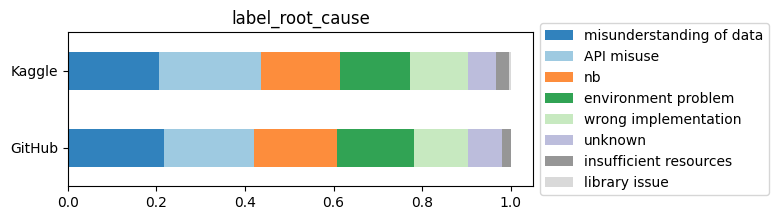

label_ML_pipeline 1
Chi2ContingencyResult: pvalue is  0.45840563880289154 (Not statistically different)


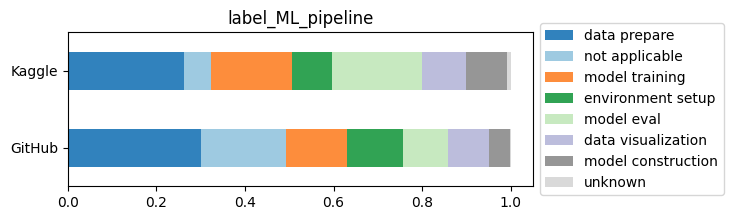

label_if_ML_bug 1
Chi2ContingencyResult: pvalue is  0.0014699902451289883 (Statistically different)


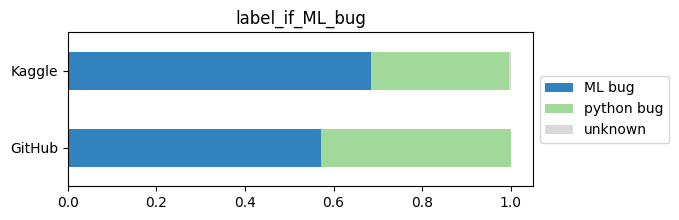

label_refined_exp_type 1
Chi2ContingencyResult: pvalue is  0.9556514502215966 (Not statistically different)


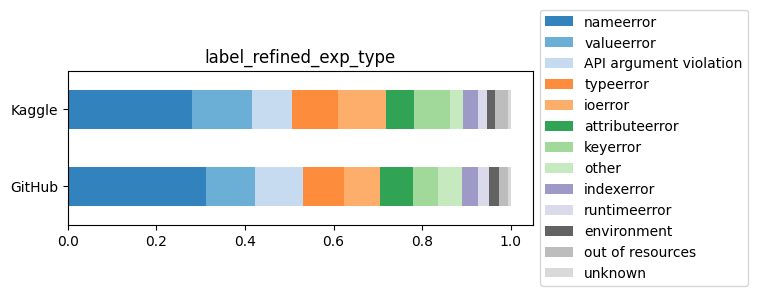

label_if_runinfo_help 0
Chi2ContingencyResult: pvalue is  0.017897367316888683 (Statistically different)


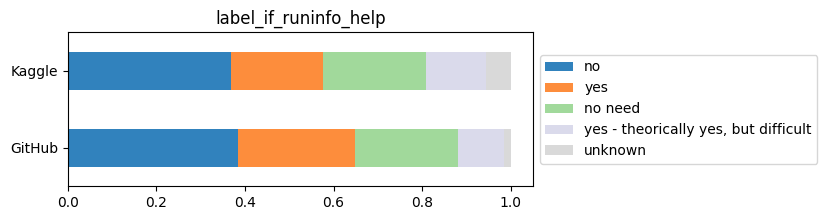

label_if_code_error_align 1
Chi2ContingencyResult: pvalue is  0.9798792842372606 (Not statistically different)


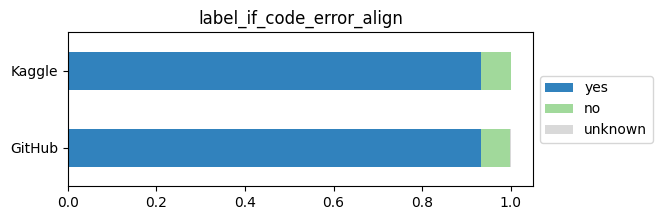

label_if_error_chain 1
Chi2ContingencyResult: pvalue is  0.3241165417200043 (Not statistically different)


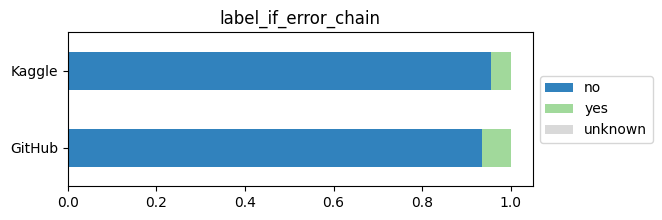

other 5
Chi2ContingencyResult: pvalue is  1.0 (Not statistically different)


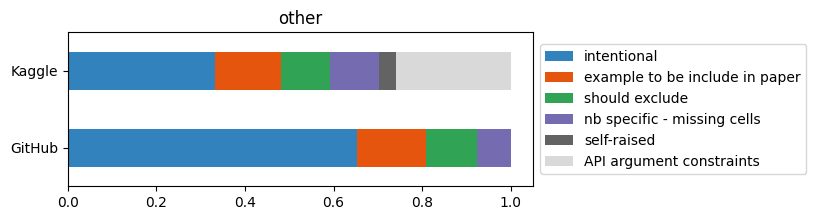

In [45]:
import numpy as np
from scipy.stats import chi2_contingency

# plot stacked bar chart to compare GitHub and Kaggle over each categories
for label_key in df_mlerr_label_config_sum:
    bar_label_key_gk = pd.DataFrame({"GitHub": cluster_res_g_sum_weighted_sum[label_key],
                                     "Kaggle": cluster_res_k_sum_weighted_sum[label_key]})
    bar_label_key_gk = bar_label_key_gk.div(bar_label_key_gk.sum(axis=0), axis=1)

    table_label_key_gk = np.array(([v for k, v in cluster_res_k_sum_weighted_sum[label_key].items()],
                                   [v for k, v in cluster_res_g_sum_weighted_sum[label_key].items()])).T
    table_label_key_gk = np.delete(table_label_key_gk, np.where(table_label_key_gk < 5)[0], axis=0)
    print(label_key,len(cluster_res_k_sum_weighted_sum[label_key])-table_label_key_gk.shape[0])
    pvalue_chisquare = chi2_contingency(table_label_key_gk).pvalue
    print("Chi2ContingencyResult: pvalue is ", pvalue_chisquare, 
          "(Not statistically different)" if pvalue_chisquare > 0.05 else "(Statistically different)")
    
    # plot
    bar_label_key_gk.T.plot(kind="barh", stacked=True, figsize=(6,2), colormap='tab20c')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title(label_key)
    plt.show()

In [31]:
import numpy as np

# plot each cluster for all categories of labels
def agg_data_for_cluster_plot(df_mlerr_label_config, cluster_res, min_size = 10, source = "GitHub"):
    plot_cluster_res = {}
    remain_cluster_res = {}

    for label_key in df_mlerr_label_config:
        remain_n = 0
        for _, row in cluster_res[label_key].iterrows():
            if (row.iloc[1][1] < min_size) or (row.cluster_id in [-100,-200]):
                remain_n += row.iloc[1][1]
                if label_key not in remain_cluster_res:
                    remain_cluster_res[label_key] = []
                remain_cluster_res[label_key].append(row)
                
            else:
                if label_key not in plot_cluster_res:
                    plot_cluster_res[label_key] = []
                plot_cluster_res[label_key].append(row.map(map_element_weights))
        if label_key in remain_cluster_res:
            remain_cluster_res[label_key] = pd.DataFrame(remain_cluster_res[label_key])

    remain_cluster_res_sum = cal_weighted_sum(df_mlerr_label_config,(remain_cluster_res))

    for label_key in df_mlerr_label_config:
        assert(remain_n == sum(remain_cluster_res_sum[label_key]))
        remain_cluster_res_sum[label_key]["cluster_id"] = -2000 if source == "GitHub" else -1000
        plot_cluster_res[label_key].append(remain_cluster_res_sum[label_key])
        plot_cluster_res[label_key] = pd.DataFrame(plot_cluster_res[label_key]).reset_index(drop=True)
        
    return plot_cluster_res

def create_colot_map_legend(df_mlerr_label_config, label_key):
    all_categories = df_mlerr_label_config[label_key][df_mlerr_label_config[label_key]!=""]
    cmap = plt.colormaps.get_cmap('hsv')
    colors = cmap(np.linspace(0, 1, len(all_categories)))
    color_map = dict(zip(all_categories, colors))
    
    legend_labels = list(color_map.keys())
    legend_colors = [color_map[cat] for cat in legend_labels]
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_colors]
    return color_map, handles

def plot_pie_chart(df, ax, color_map, title):
    for cat in df.index:
        if cat not in color_map:
            print(cat)
#         print(df.index)
    colors = [color_map[cat] for cat in df.index[df.index!=""]]
    df.plot.pie(ax=ax, legend = False, labeldistance = None, 
                colors=colors, autopct='%1.1f%%', fontsize = 7, title = title)
        
def plot_dist_labels_clusters(df_mlerr_label_config, cluster_res, min_size = 10, source="GitHub"):
    
    plot_cluster_res = agg_data_for_cluster_plot(df_mlerr_label_config, cluster_res, min_size, source = "GitHub")
    
    n_clusters = len(plot_cluster_res[df_mlerr_label_config.columns[0]])
    
    for label_key in df_mlerr_label_config:
        fig, axs = plt.subplots(math.ceil(n_clusters/2), 2, figsize=(9, 6*math.ceil(n_clusters/2)))
        
        #legend covered all
        color_map, handles = create_colot_map_legend(df_mlerr_label_config, label_key)
        
        for i in range(0, n_clusters, 2):
            plot_pie_chart(plot_cluster_res[label_key].iloc[i,1:], axs[i//2,0], color_map, 
                           source+" - "+str(plot_cluster_res[label_key].iloc[i,0])+label_key)
            if i+1 > math.ceil(n_clusters/2):
                break
            plot_pie_chart(plot_cluster_res[label_key].iloc[i+1,1:], axs[i//2,1], color_map,
                           source+" - "+str(plot_cluster_res[label_key].iloc[i+1,0])+label_key)
        
        # Create a common legend
        fig.legend(handles, list(color_map.keys()), loc='center left', bbox_to_anchor=(1, 0.5))

#         axs[0,0].legend(handles_axs, labels_axs, bbox_to_anchor=(2.3, 0), loc='lower left')
        plt.show()
    
# plot weighted sum for all categories of labels for both sources
def plot_dist_labels(df_mlerr_label_config, cluster_res_weighted_sum_g, cluster_res_weighted_sum_k):
    for label_key in df_mlerr_label_config:
        fig, axs = plt.subplots(1, 2, figsize=(9, 12))
        color_map, handles = create_colot_map_legend(df_mlerr_label_config, label_key)
        plot_pie_chart(cluster_res_weighted_sum_g[label_key], axs[0], color_map, "GitHub - "+label_key)
        plot_pie_chart(cluster_res_weighted_sum_k[label_key], axs[1], color_map, "Kaggle - "+label_key)
        fig.legend(handles, list(color_map.keys()), loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

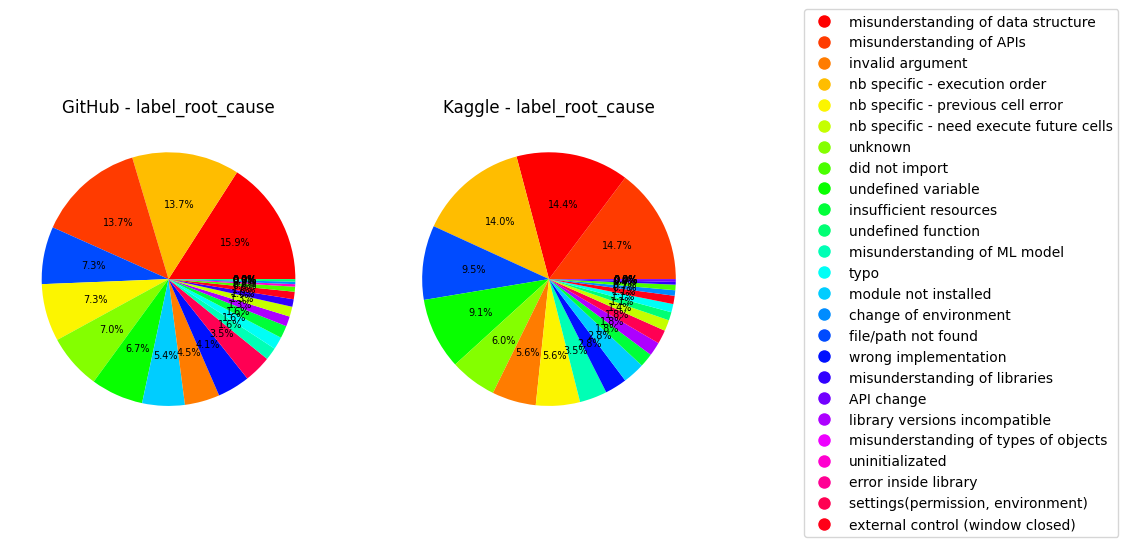

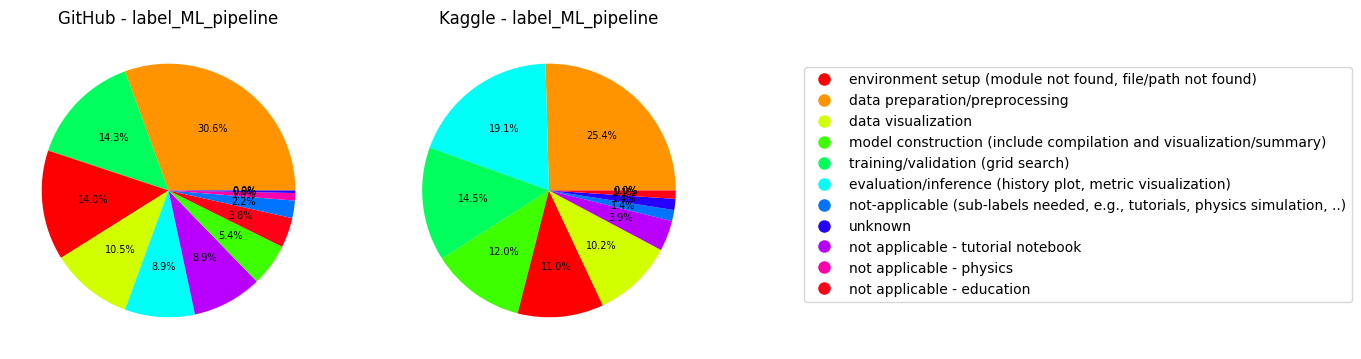

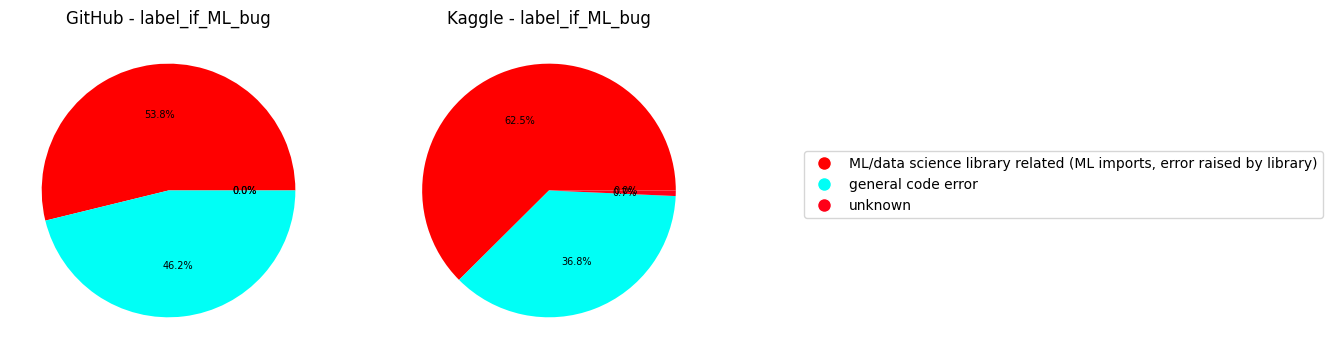

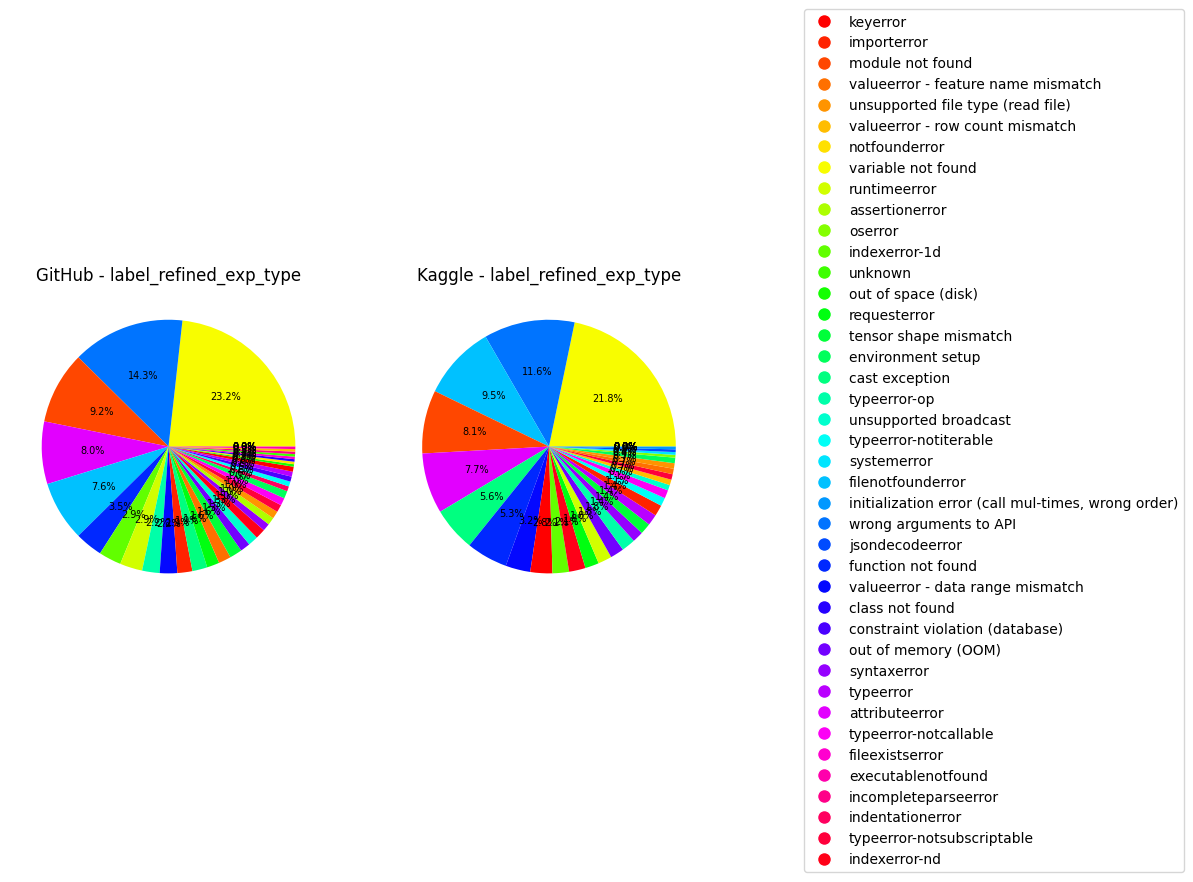

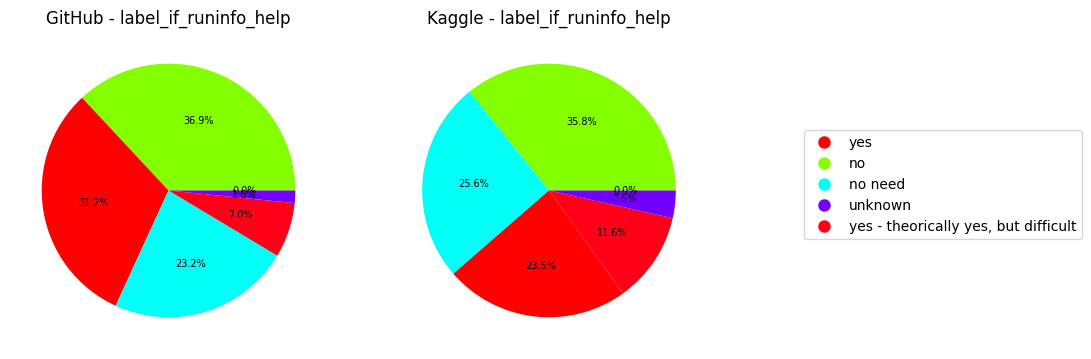

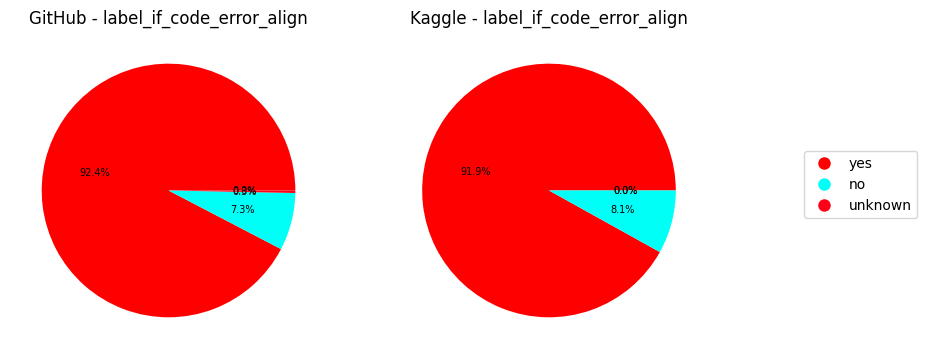

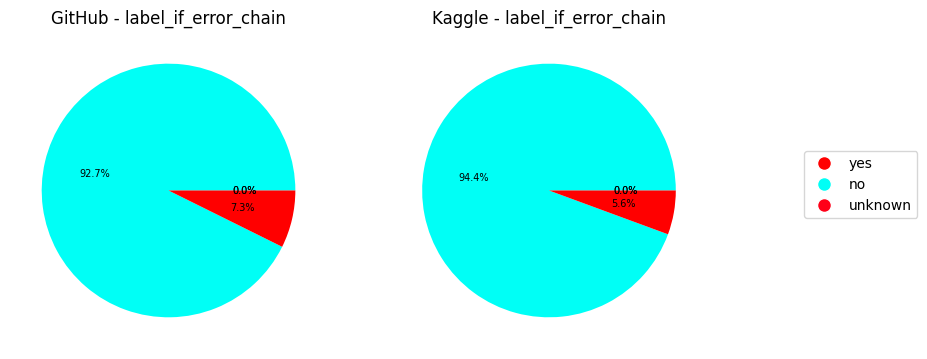

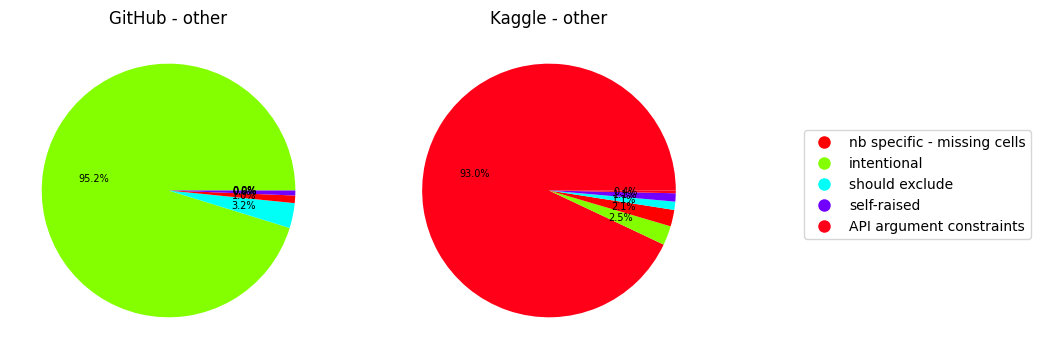

In [34]:
# plot across clusters, github kaggle side by side

plot_dist_labels(df_mlerr_label_config, cluster_res_g_weighted_sum, cluster_res_k_weighted_sum)

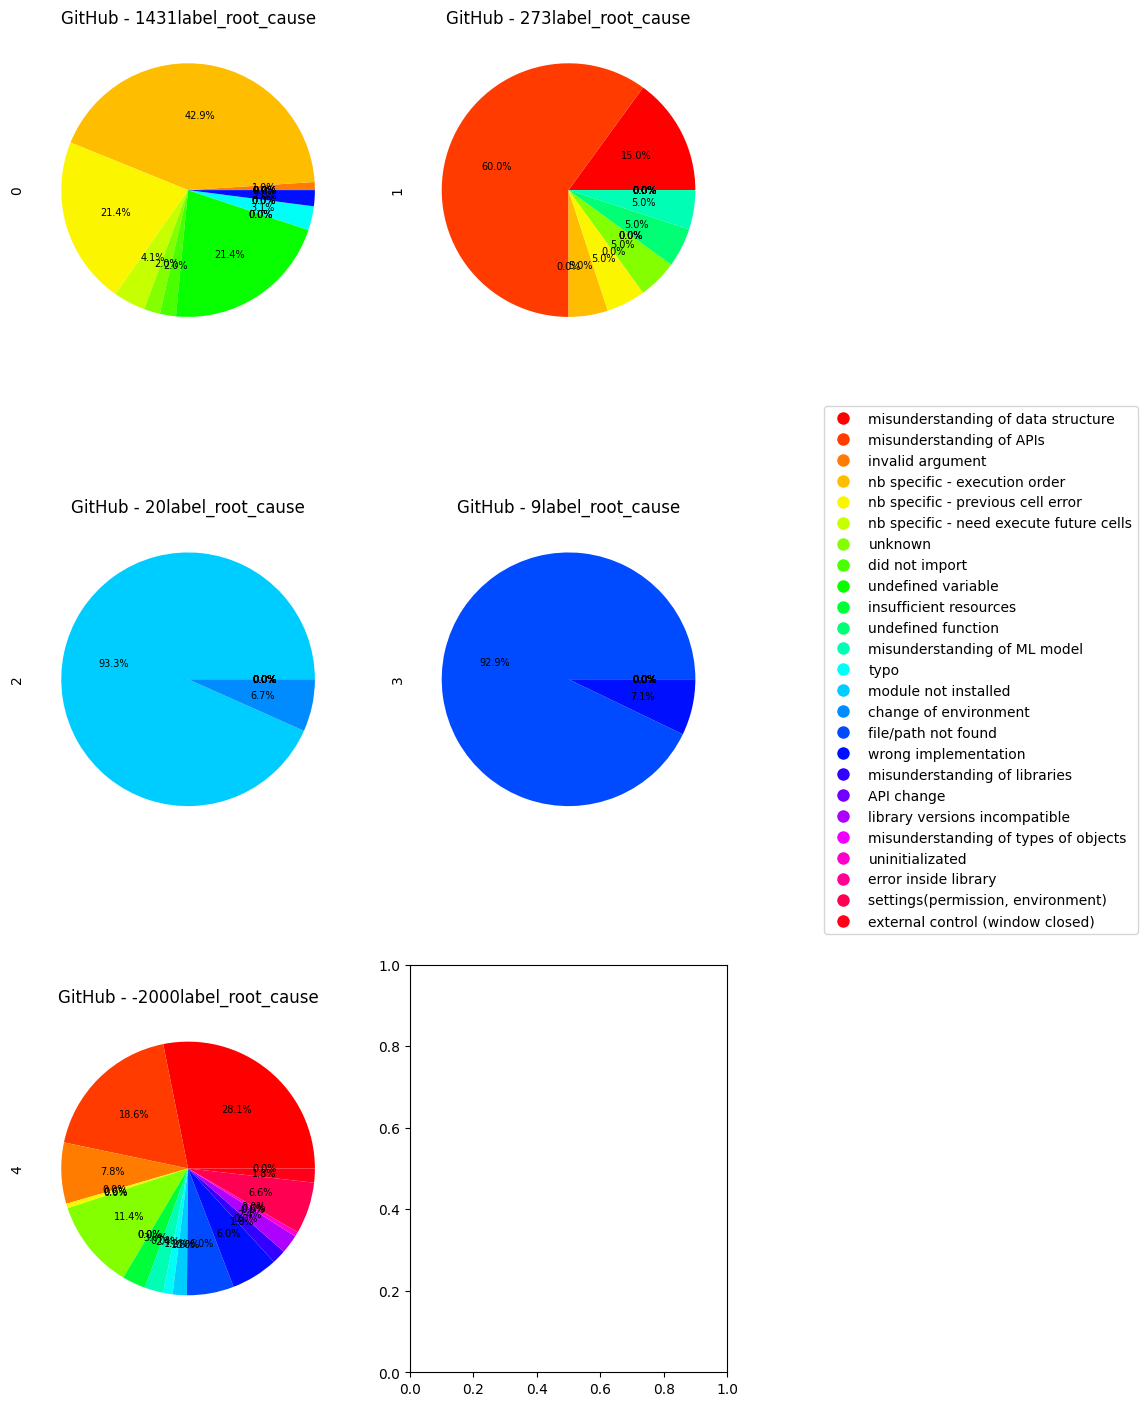

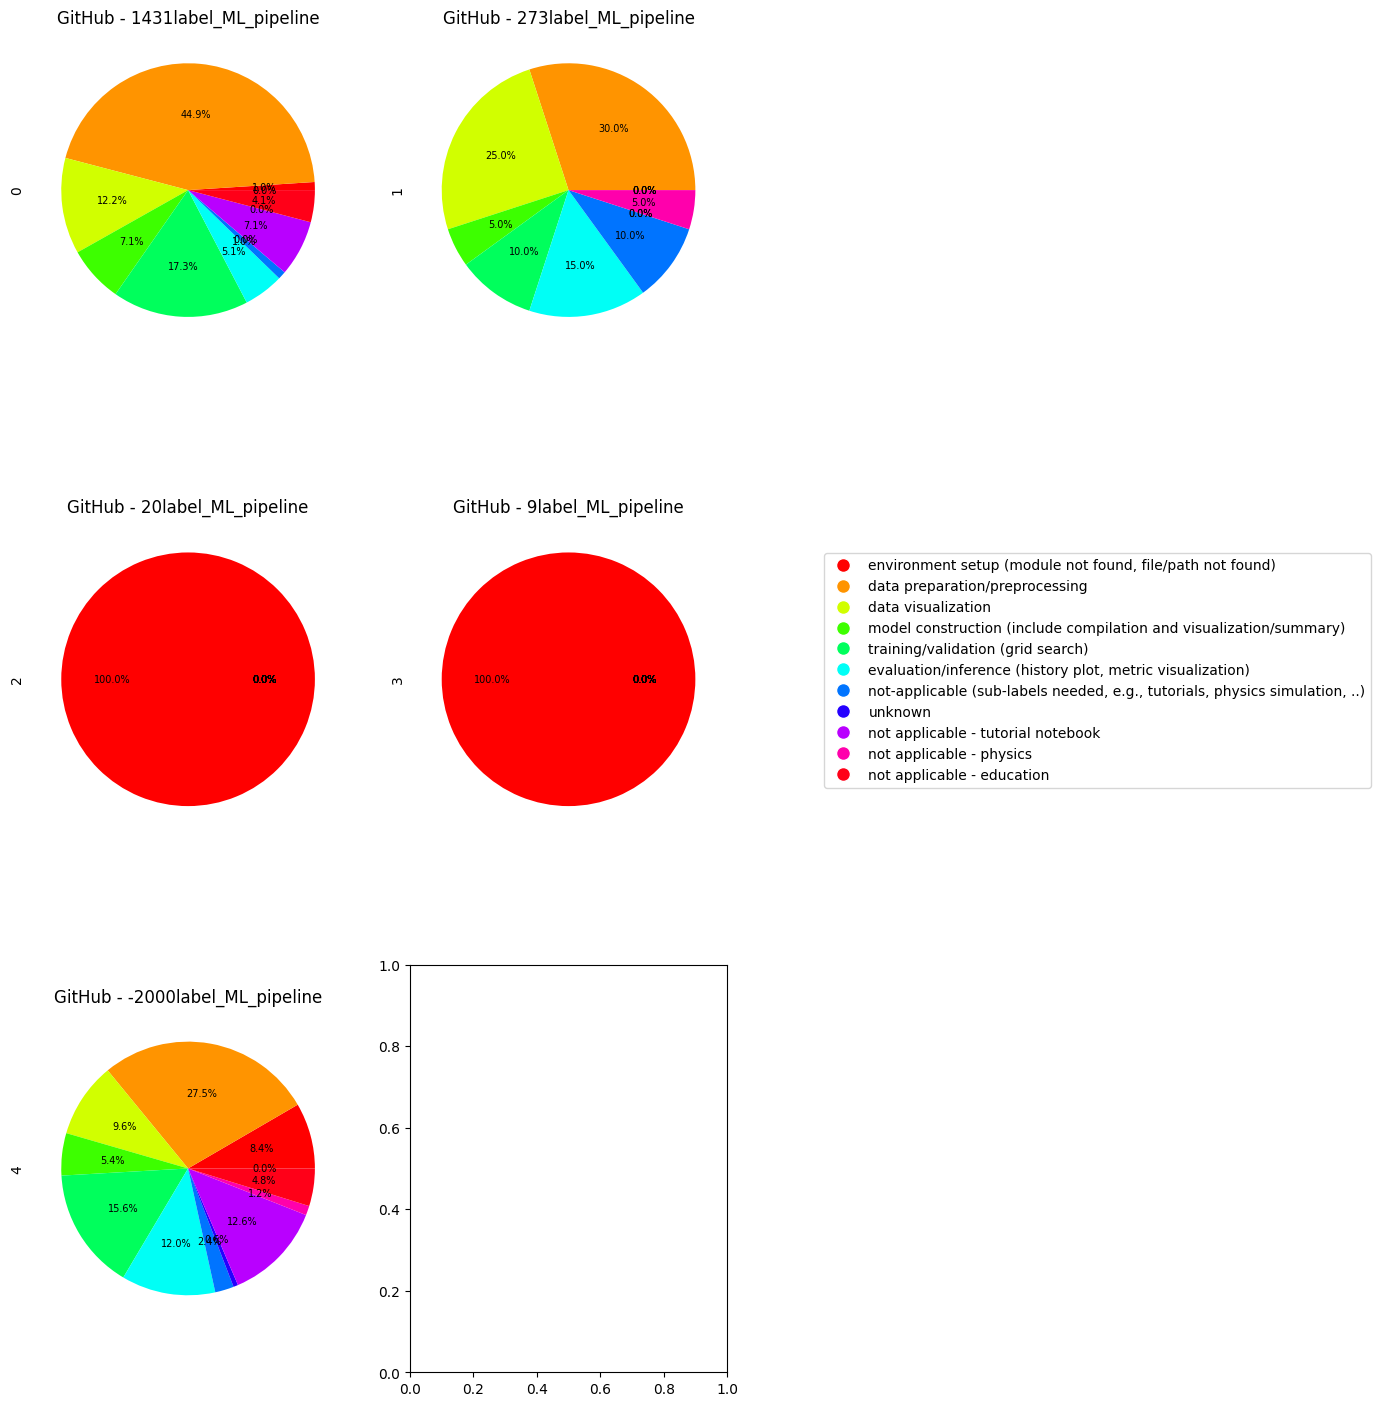

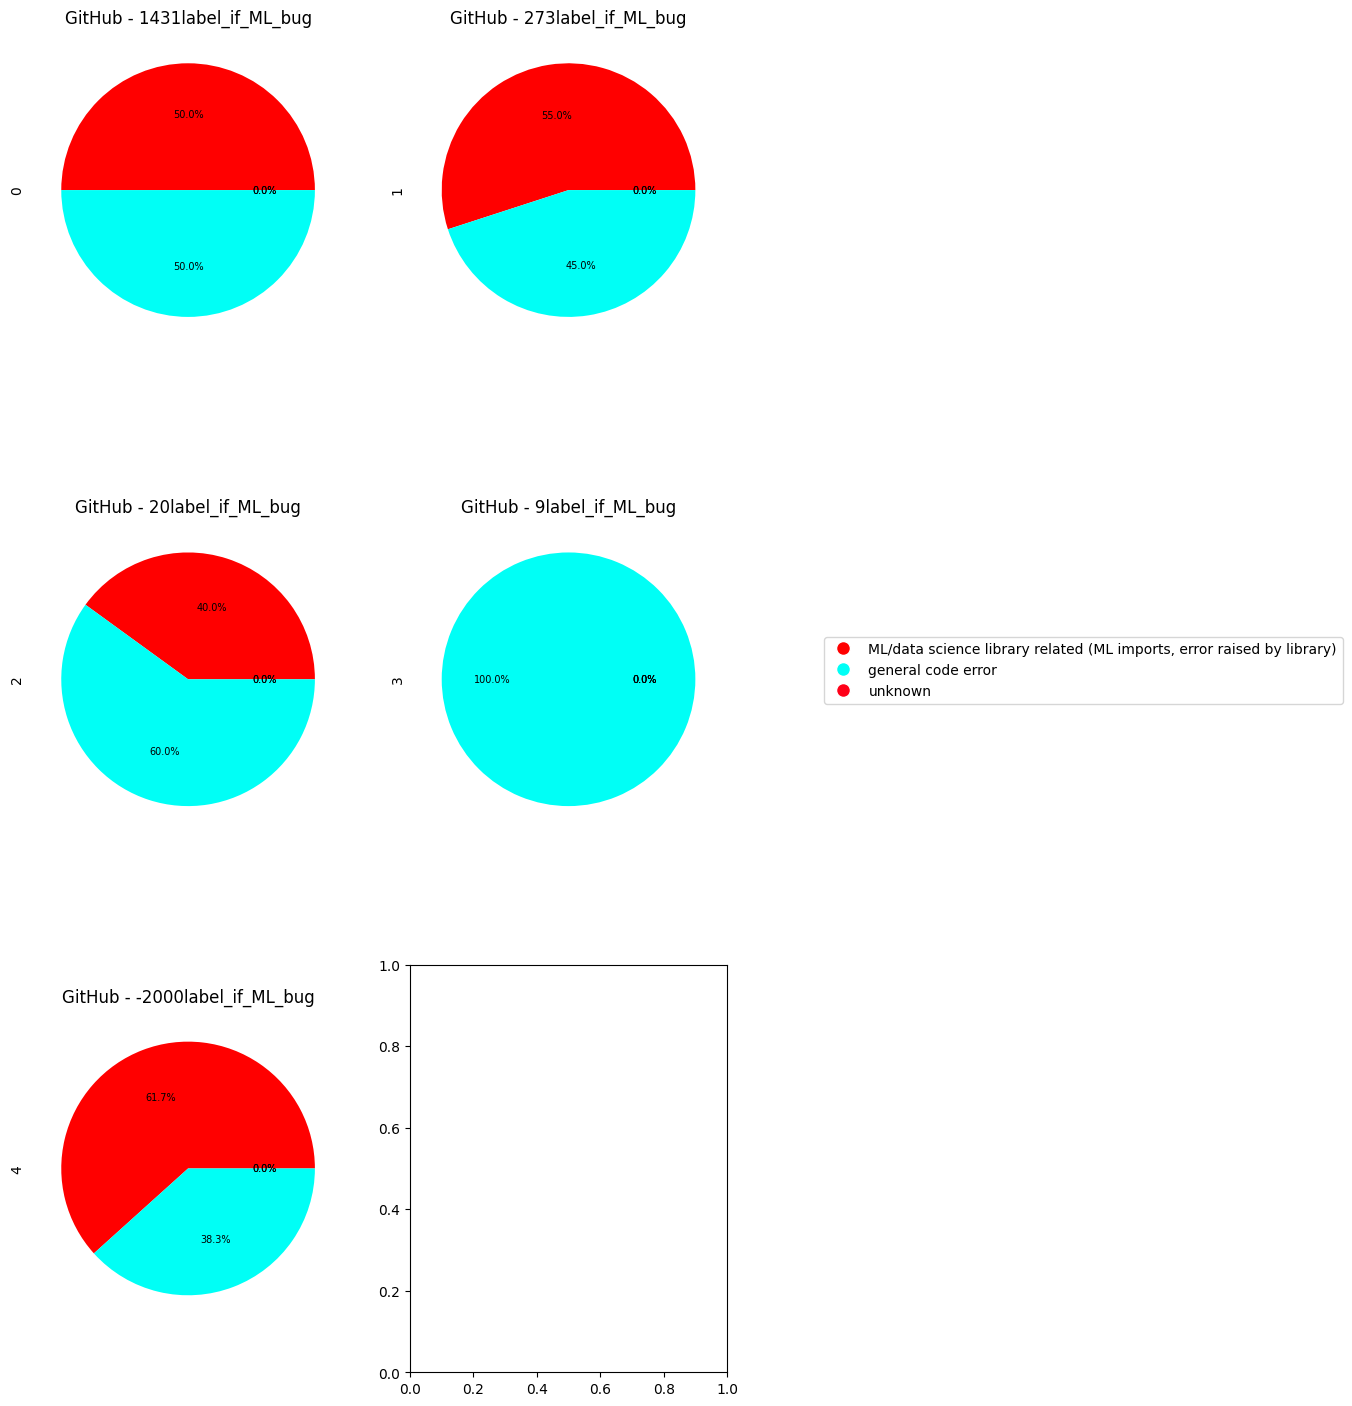

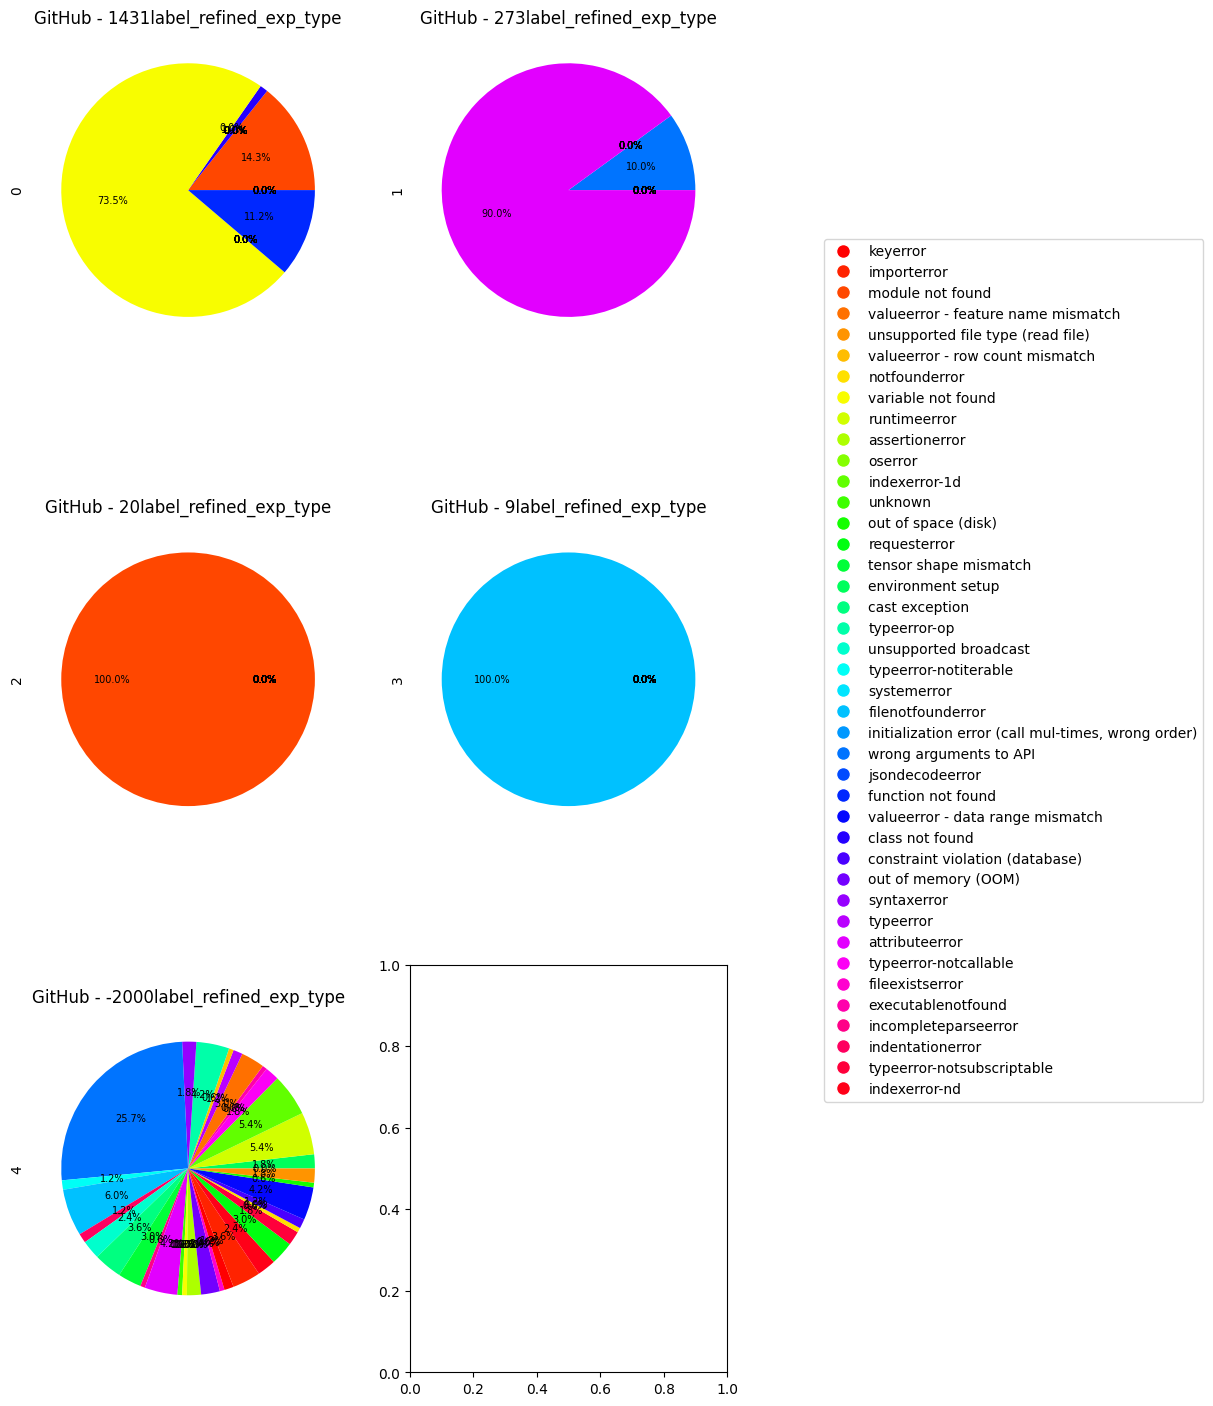

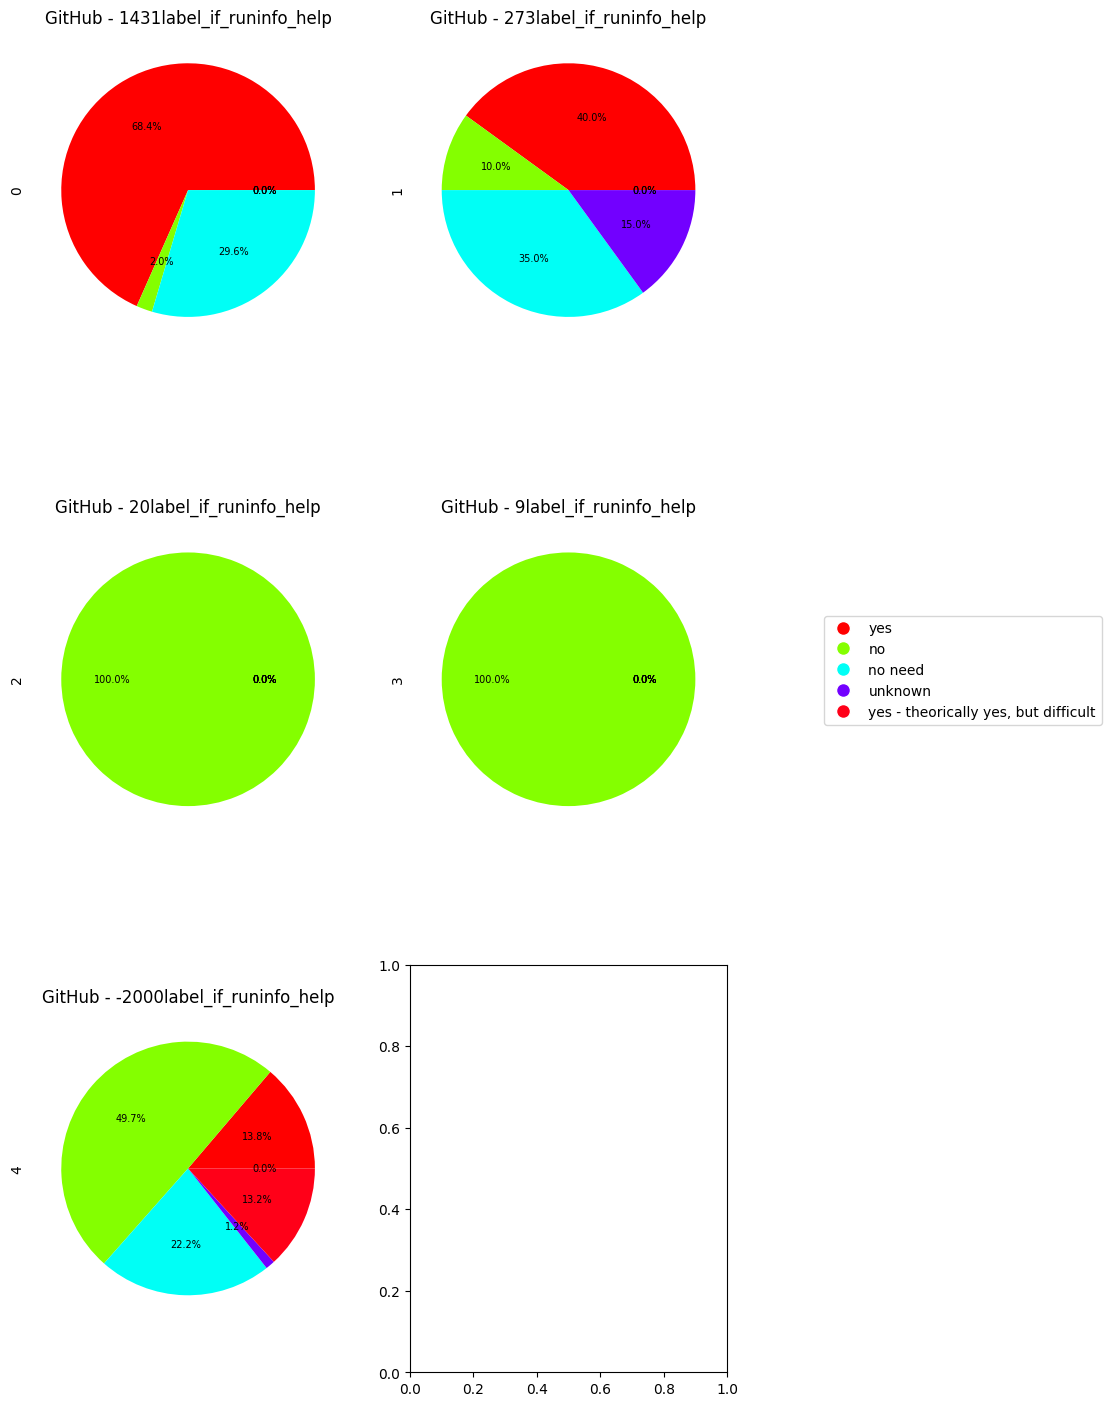

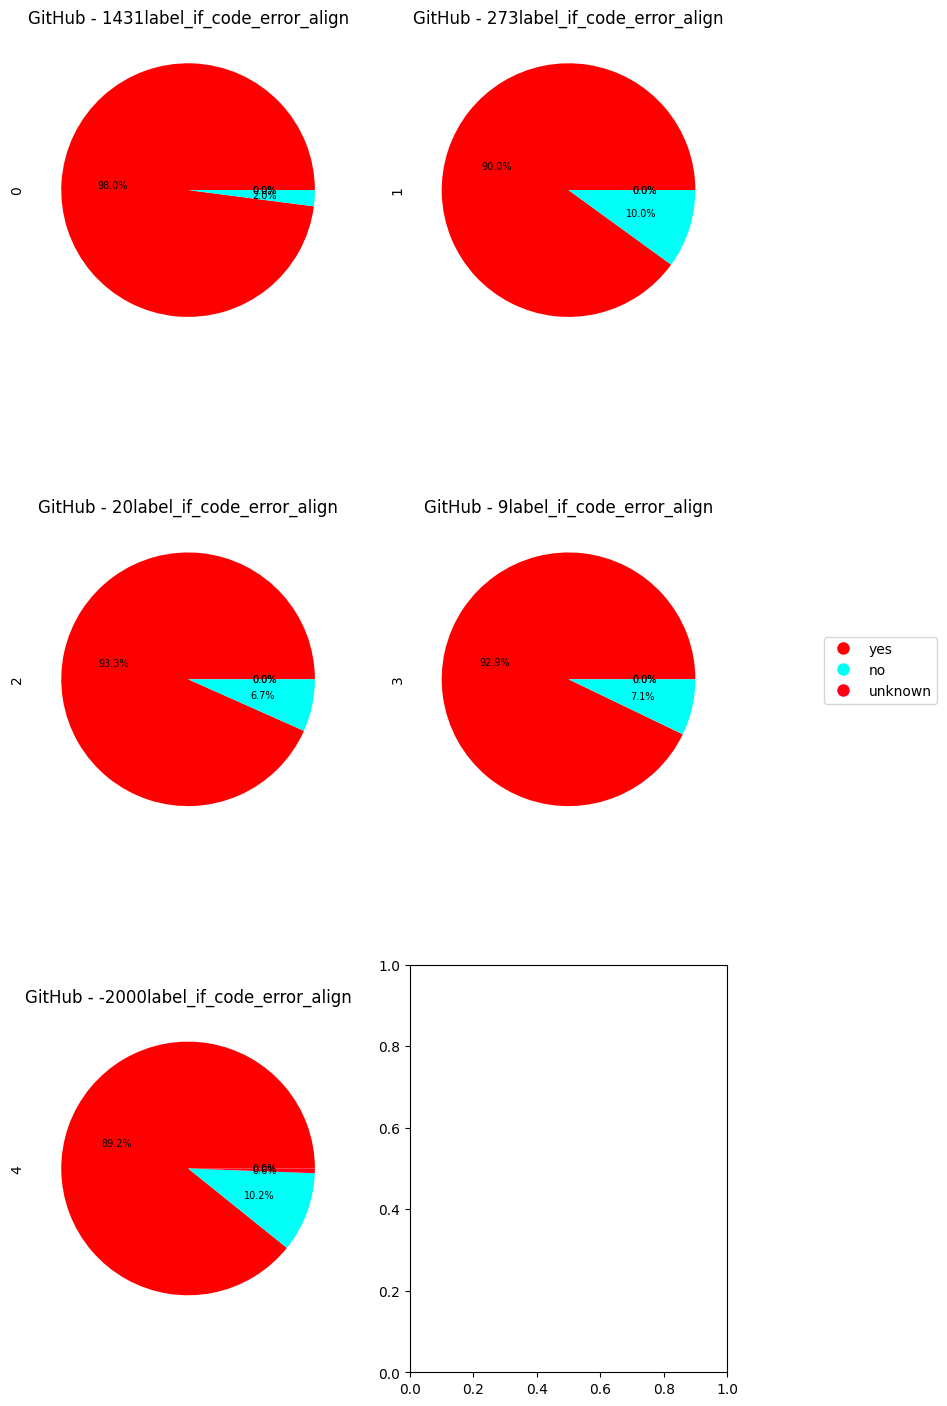

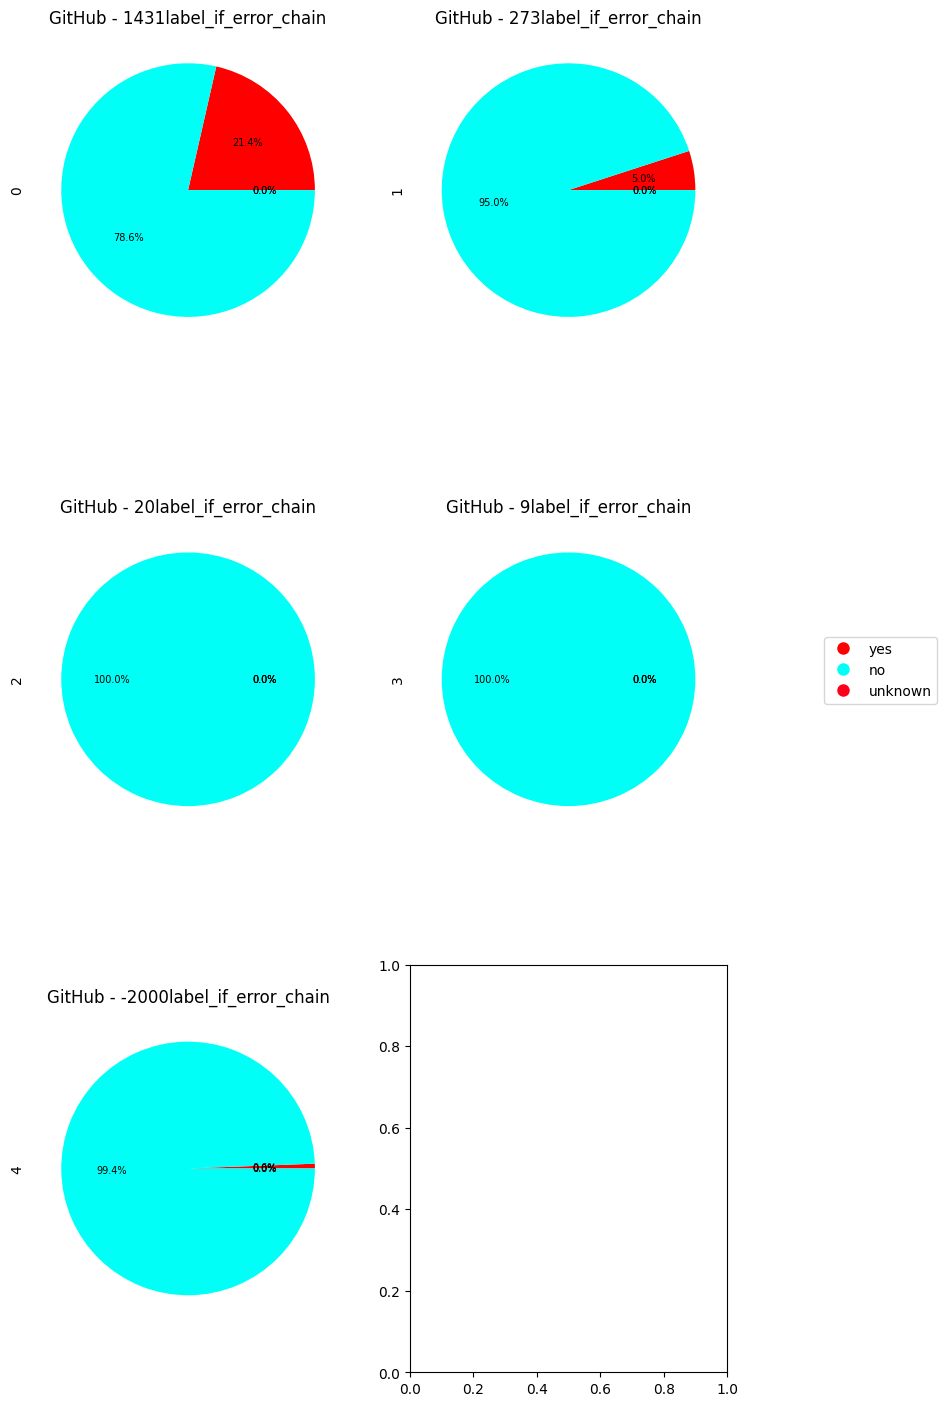

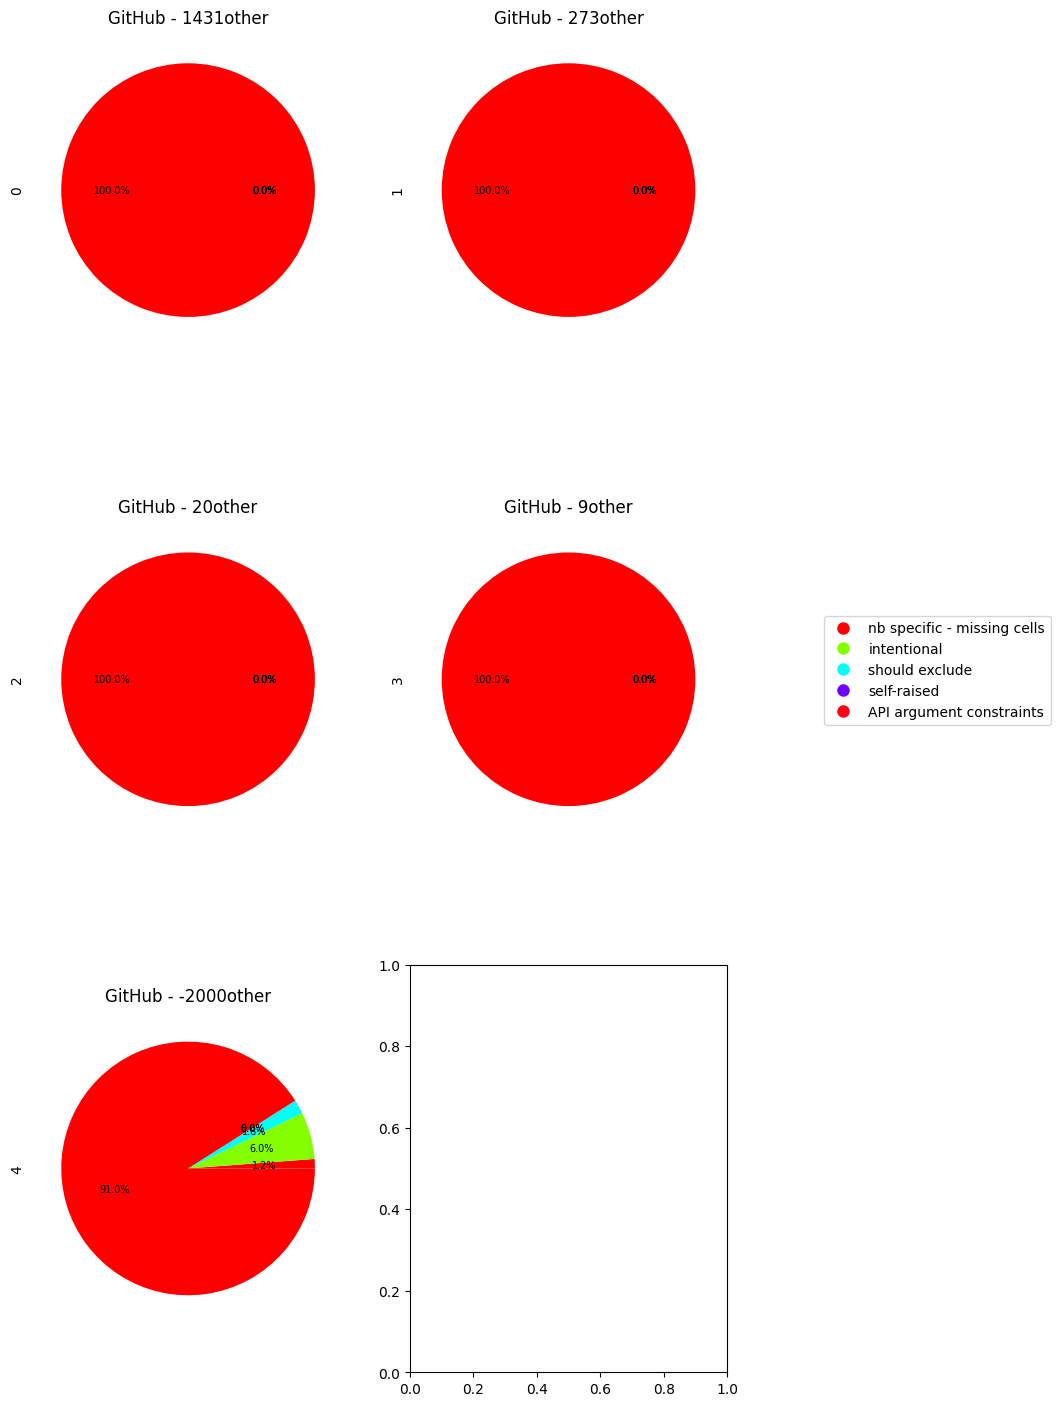

In [32]:
# plot Github labels based on clusters
plot_dist_labels_clusters(df_mlerr_label_config, cluster_res_g, source="GitHub")

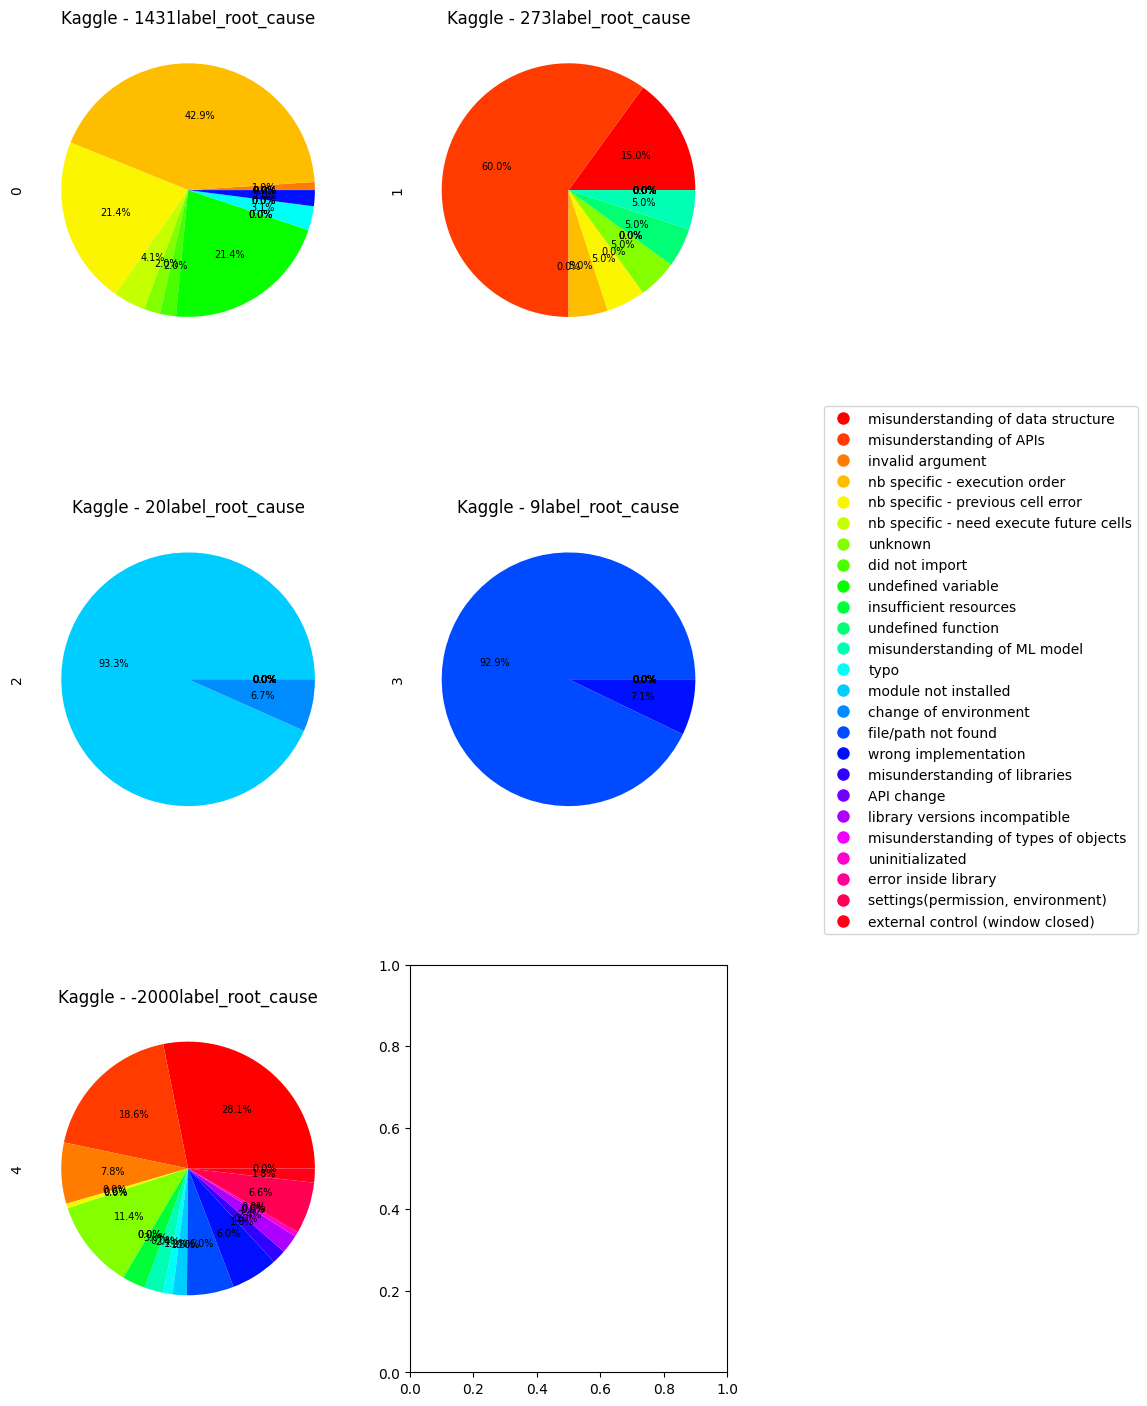

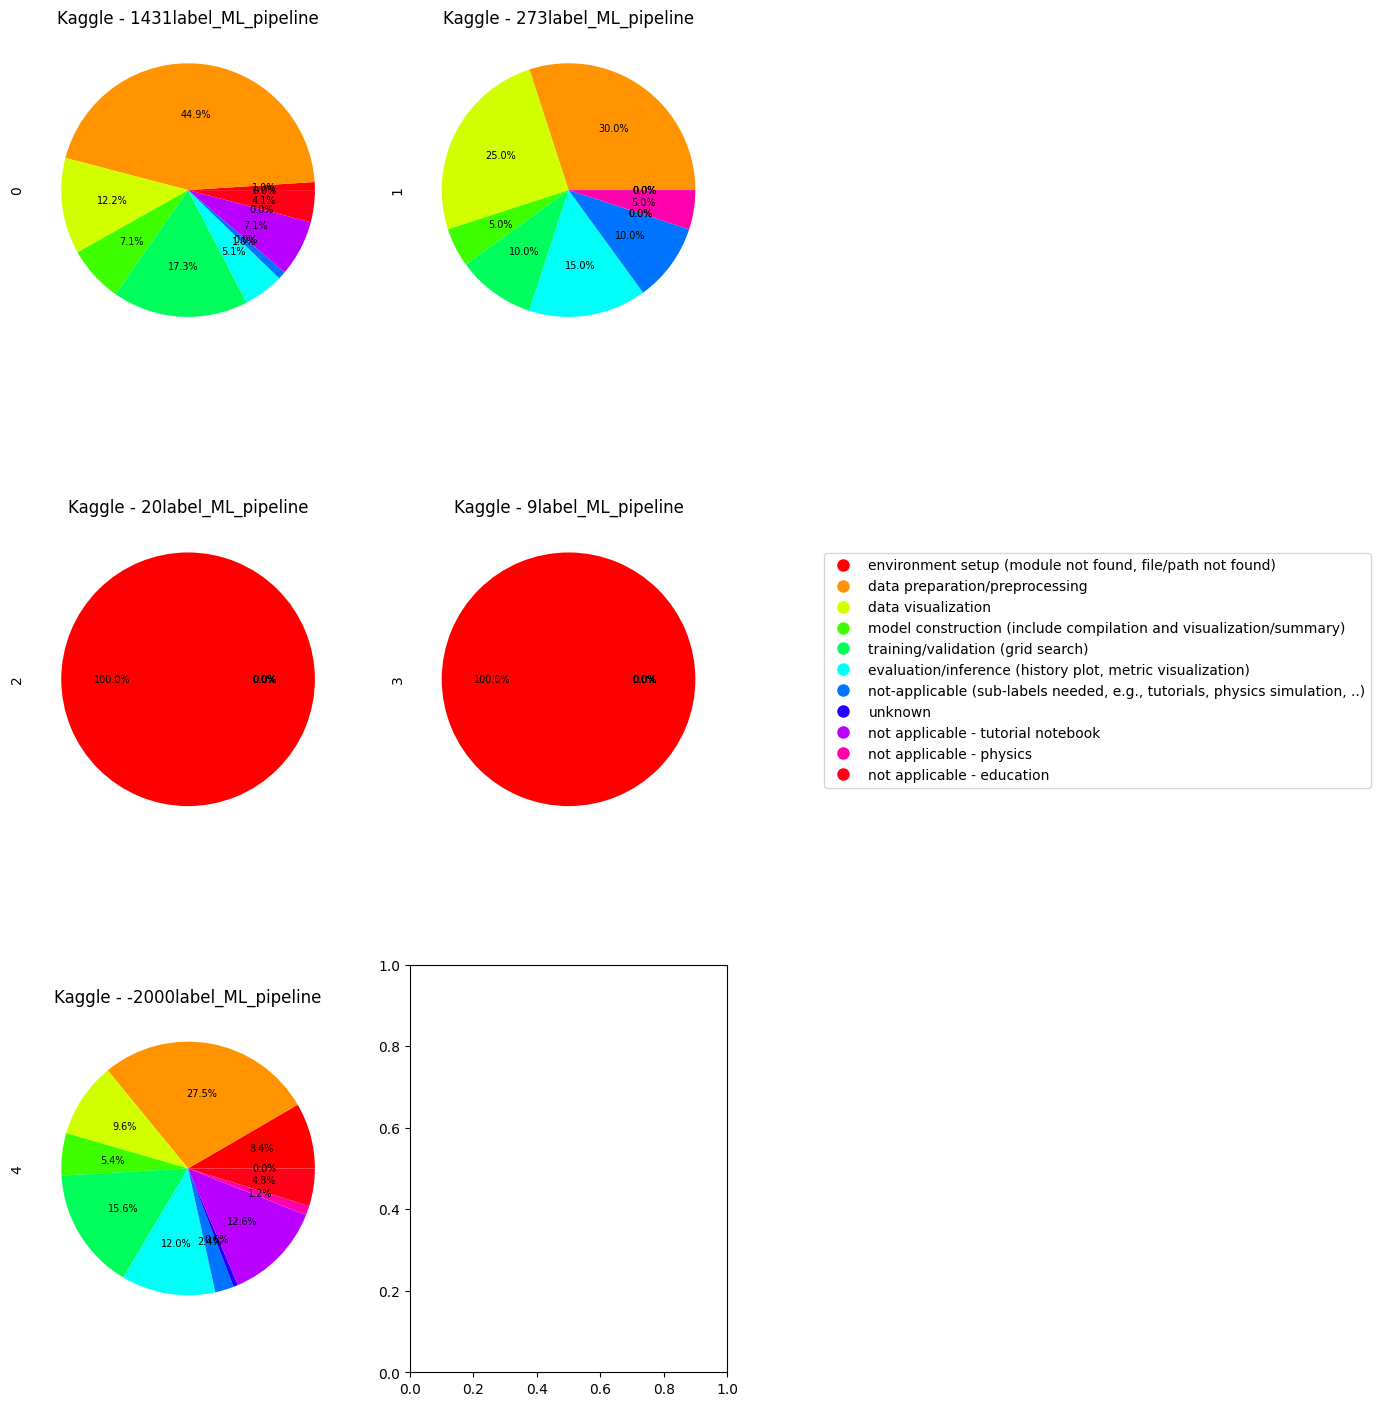

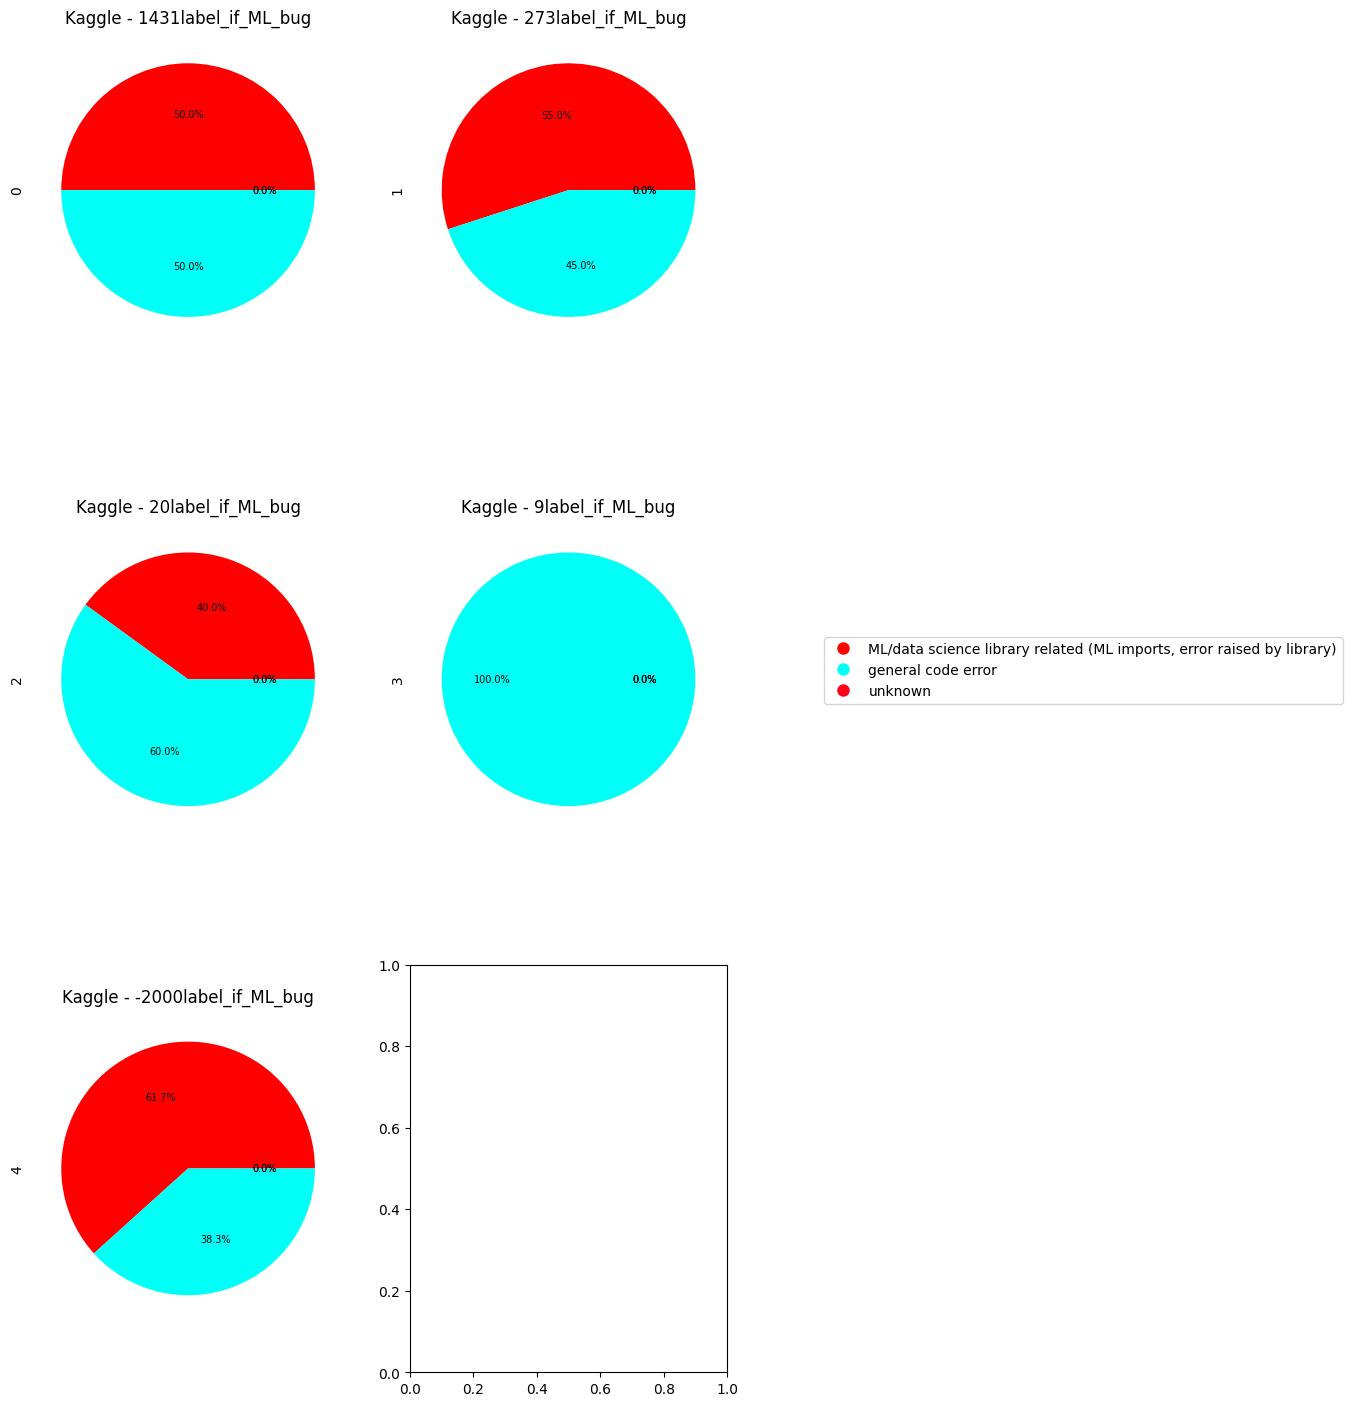

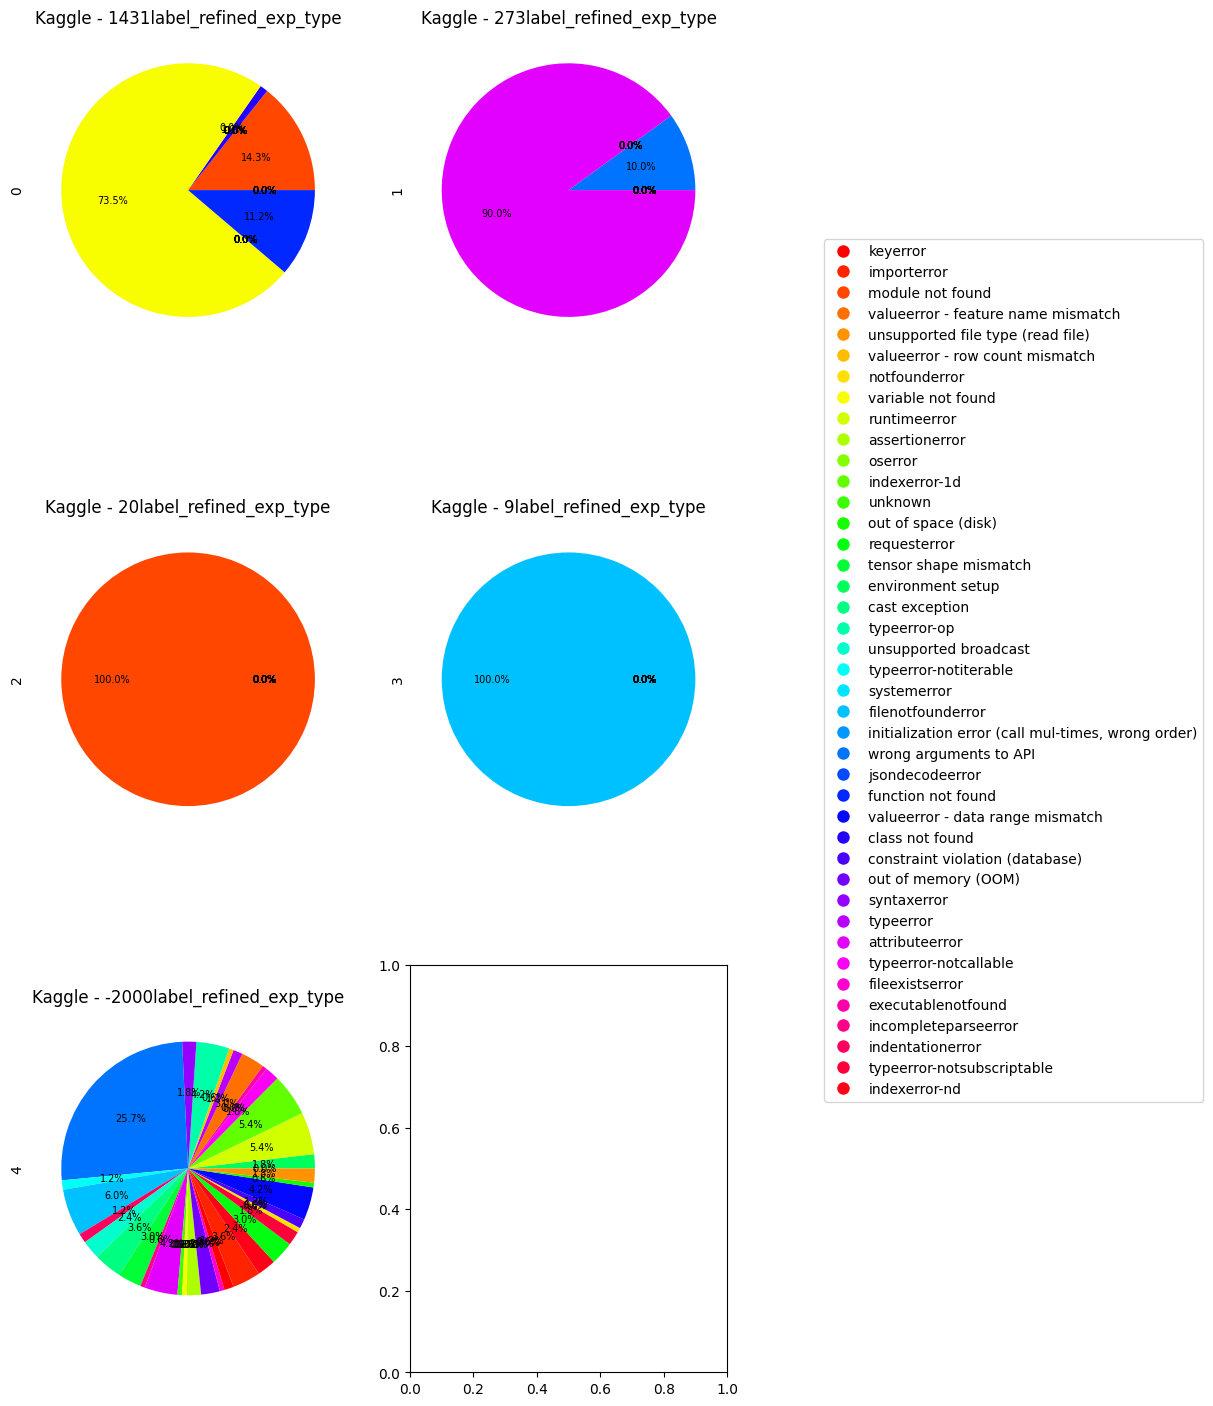

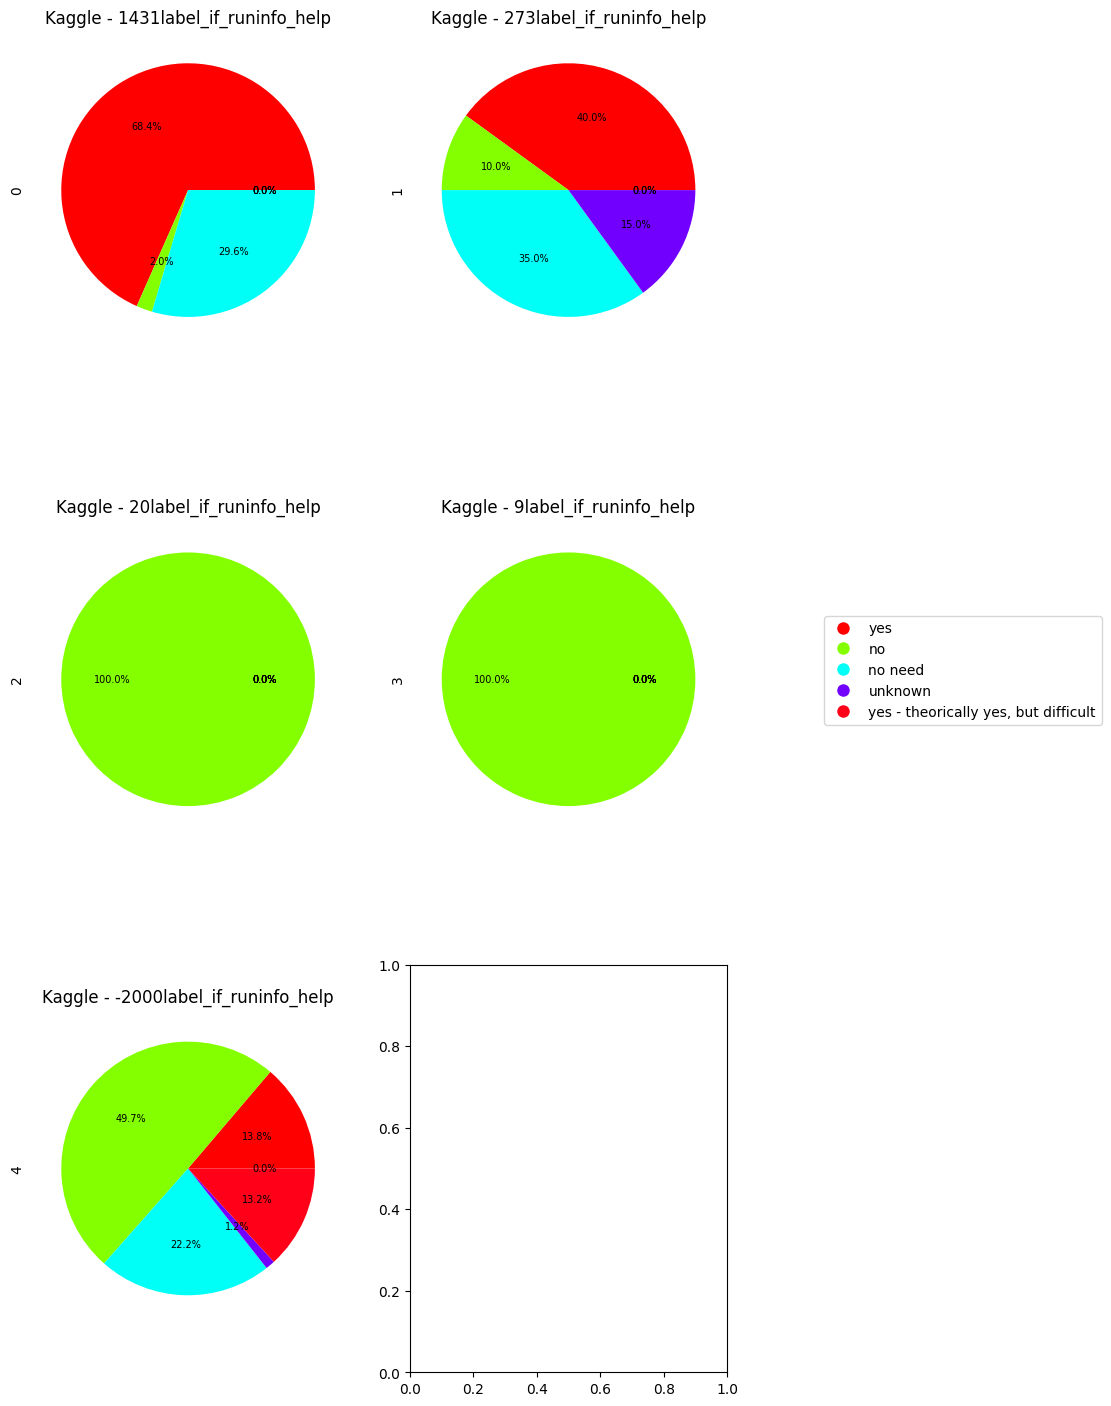

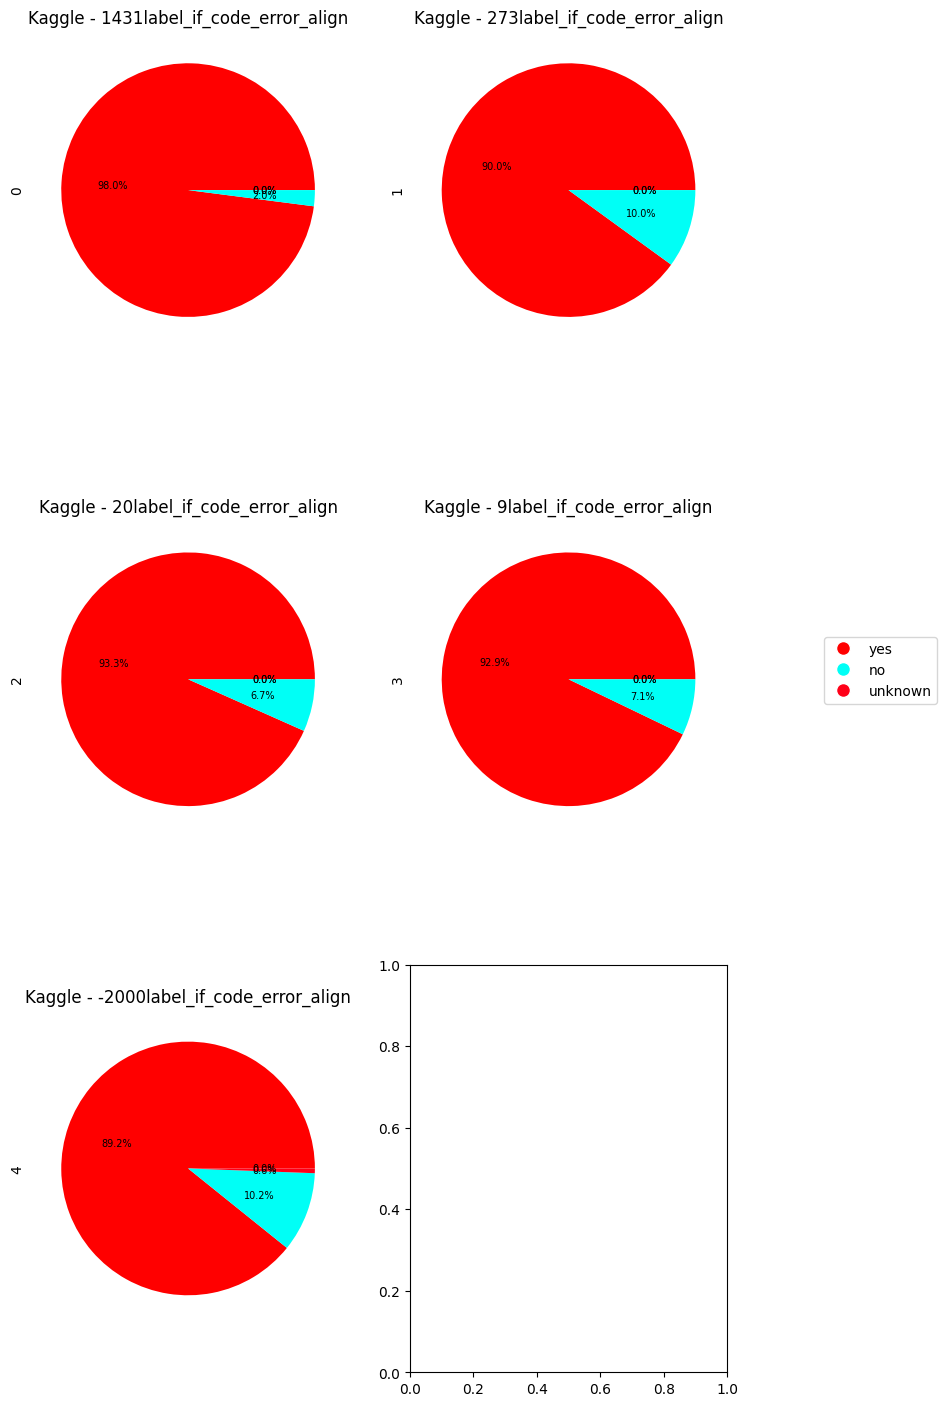

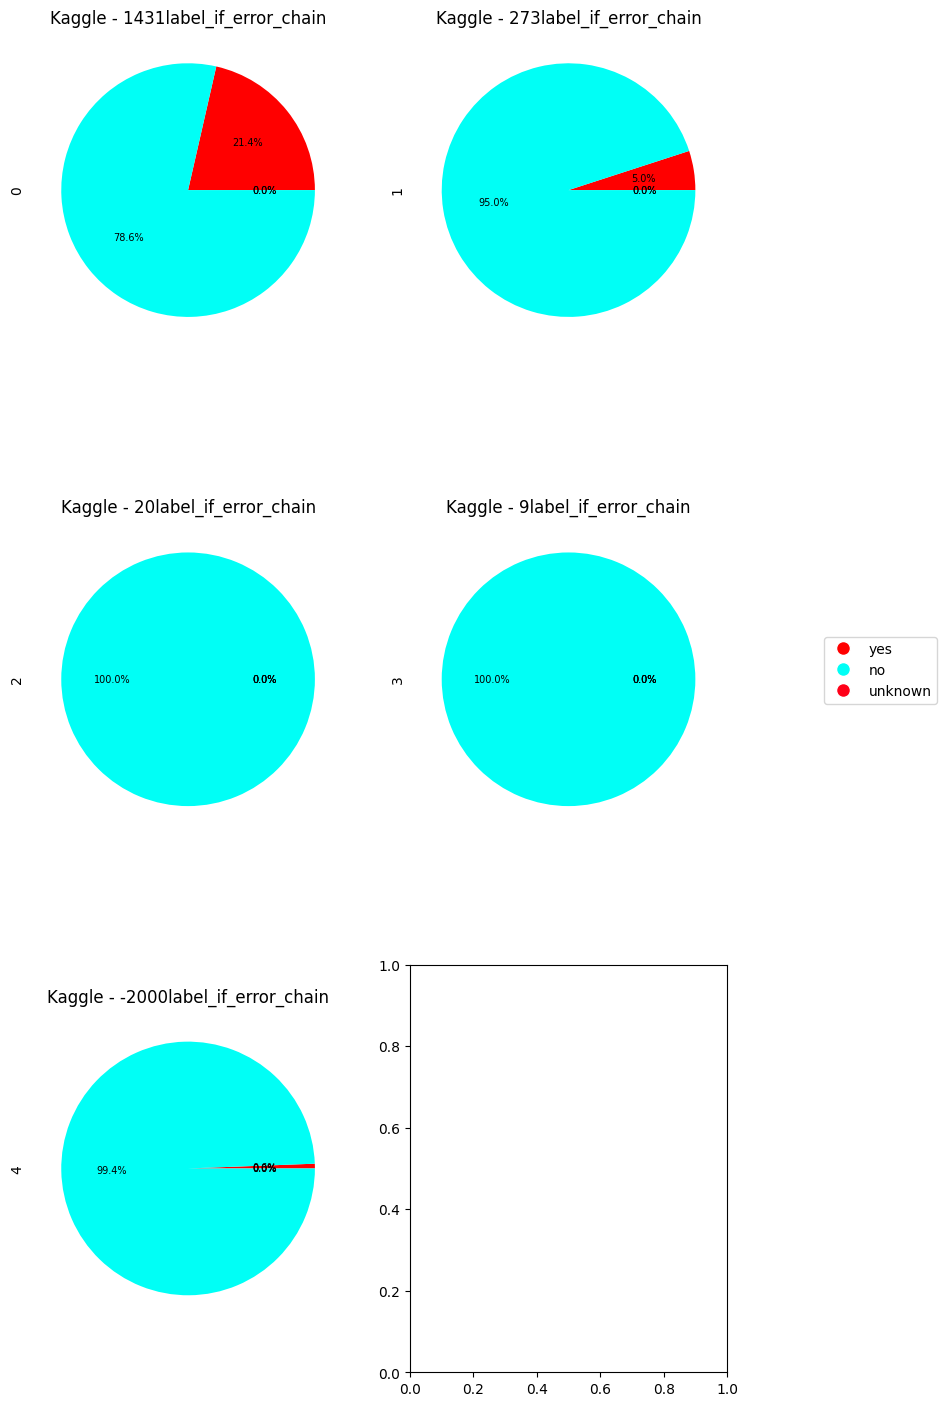

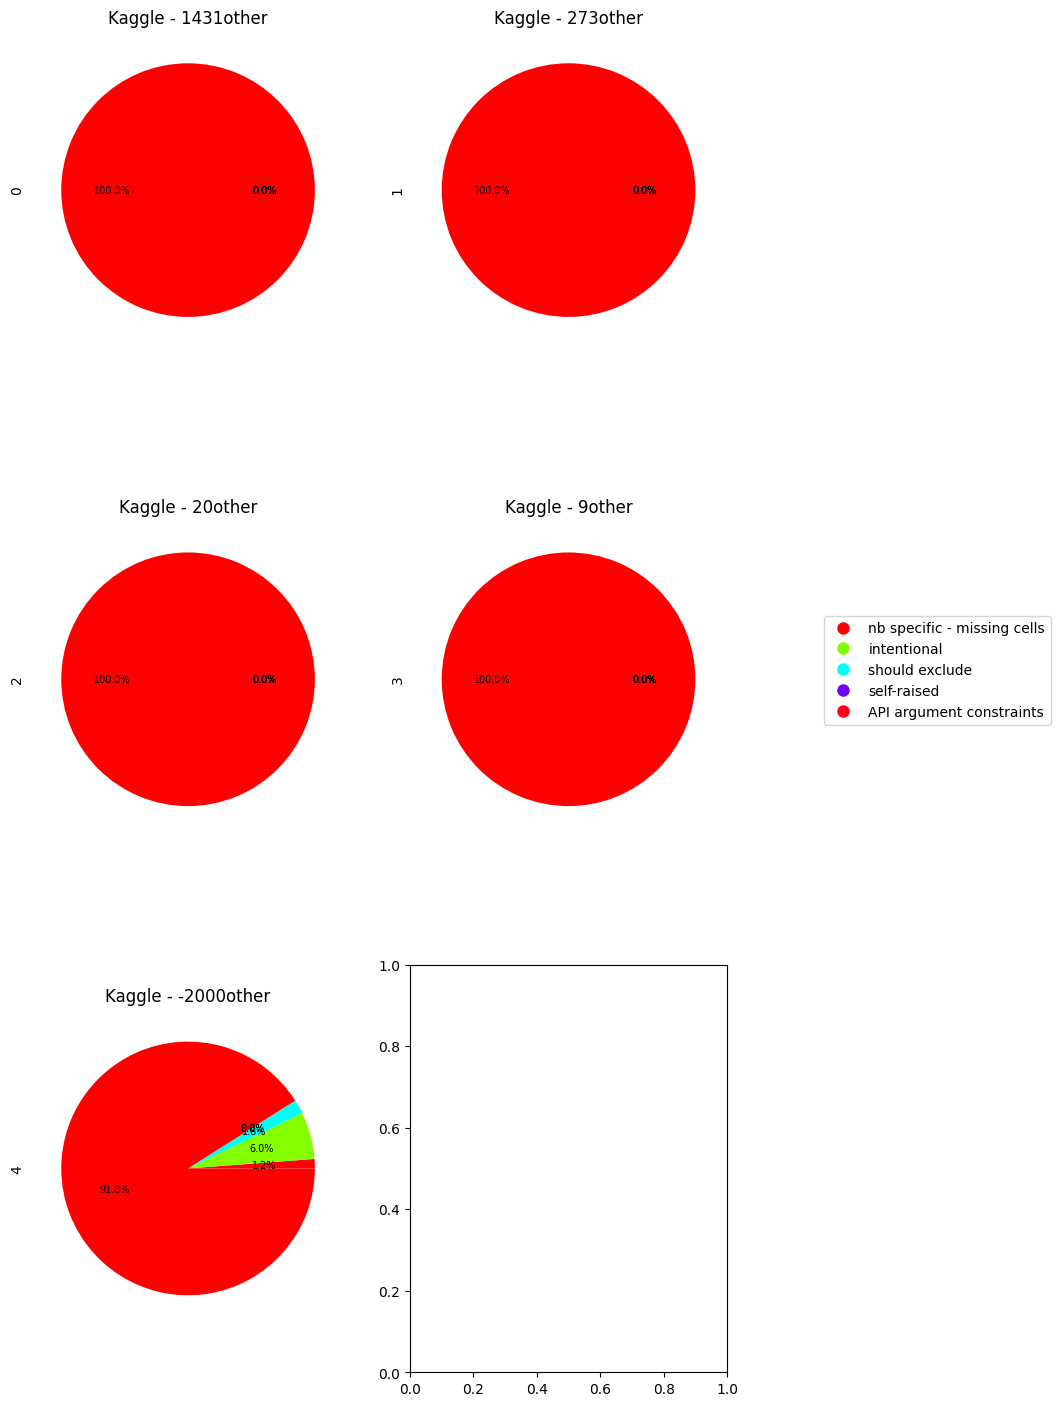

In [33]:
# plot kaggle labels based on clusters
plot_dist_labels_clusters(df_mlerr_label_config, cluster_res_k, source="Kaggle")

In [22]:
# # calculate margin of errors at a confidence level of 95%
# # Moore, D. S. and McCabe G. P. Introduction to the Practice of Statistics. New York: W. H. Freeman, p. 443, 1999.
# # z* sqrt(p(1-p)/sample_size)
# # combine errors across clusters: https://www.met.rdg.ac.uk/~swrhgnrj/combining_errors.pdf

# import math
# import numpy as np

# def moe(p, sn):
#     # Because p^(1−p^) will be close to (but slightly less than) 1/4 when p^ is anywhere near 50%, 
#     #we may conservatively overestimate the standard error even before taking the poll by using 1/4 in the calculation. 
#     #That is, the largest possible standard error of any response in a poll of n observations is sqrt(1/(4n))
#     #need find the reference for this
#     return 1.645 * math.sqrt(p*(1-p)/4/sn) # 0.9-1.645, 0.95-1.96

# def moe_sample(x):
#     if isinstance(x, tuple):
#         if x[1] > 0:
#             return moe(x[0]/x[1], x[1])
#     return 0

# def cal_moe(df_mlerr_label_config, cluster_res):
#     cluster_res_moes = {}
#     for label_key in df_mlerr_label_config:
#         cluster_res_moe = cluster_res[label_key].iloc[:, 1:].map(moe_sample)
#         cluster_res_moes[label_key] = np.sqrt(cluster_res_moe.pow(2).sum()).sort_values(ascending=False)
#     return cluster_res_moes

# def display_df_by_config(df_mlerr_label_config, cluster_df):
#     for label_key in df_mlerr_label_config:
#         display(cluster_df[label_key])

In [11]:
# # calculate variances
# def var(p, n):
#     return n*p*(1-p)

# def var_sample(x):
#     if isinstance(x, tuple):
#         if x[1] > 0:
#             return var(x[0]/x[1], x[1])
#     return 0

# def cal_var(df_mlerr_label_config, cluster_res):
#     cluster_res_vars = {}
#     for label_key in df_mlerr_label_config:
#         cluster_res_var = cluster_res[label_key].iloc[:, 1:].map(var_sample)
#         cluster_res_vars[label_key] = cluster_res_var
#     return cluster_res_vars

# def plot_var_by_config(df_mlerr_label_config, cluster_df):
#     for label_key in df_mlerr_label_config:
#         ax = cluster_df[label_key].plot(title=label_key, ylim=(-3,10), xlabel=None)
#         ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
#         plt.show()

# cluster_res_all_variances = cal_var(df_mlerr_label_config, cluster_res_all)
# plot_var_by_config(df_mlerr_label_config, cluster_res_all_variances)

In [12]:
# # calculate weights based on cluster size
# # assuming the samples represent the cluster population
# def map_element_weights(x):
#     if isinstance(x, tuple):
#         if x[1] > 0:
#             return x[0]/x[1]*x[2]
#         else:
#             return 0
#     else:
#         return x

# # summarize across clusters based on the weights calculated with cluster sizes
# # sorted 
# def cal_weighted_sum(df_mlerr_label_config, cluster_res):
#     cluster_res_weighted_sum = {}
#     for label_key in df_mlerr_label_config:
#         cluster_res_weight = cluster_res[label_key].map(map_element_weights)
#         cluster_res_weighted_sum[label_key] = cluster_res_weight.iloc[:, 1:].sum().sort_values(ascending=False)
#     return cluster_res_weighted_sum

# # plot weighted sum for all categories of labels
# def plot_dist_labels(df_mlerr_label_config, cluster_res_weighted_sum):
#     for label_key in df_mlerr_label_config:
#         ax = cluster_res_weighted_sum[label_key].plot.pie(figsize=(5, 5),
#                                                           legend=True, labeldistance=None,
#                                                           autopct='%1.1f%%', fontsize=7,
#                                                           title = label_key)
#         ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
#         plt.show()

In [12]:
# cluster_res_all = load_statistics(config.path_default.joinpath("data_dedup_cluster/sample2_statistics_all.pickle"))
# for label_key in df_mlerr_label_config:
#     cluster_res_all[label_key] = pd.DataFrame.from_dict(cluster_res_all[label_key]).rename_axis('cluster_id').reset_index()

# cluster_res_all_moes = cal_moe(df_mlerr_label_config, cluster_res_all)
# display_df_by_config(df_mlerr_label_config, cluster_res_all_moes)

In [13]:
# # sampling

# # calculate overall sample size with stratified sampling
# # def sample_size(e):
# #     nh_n = Nh * np.sqrt(Sh2) / sum(Nl*np.sqrt(Sl2))
# #     v = sum(nh_n * (Nh/N)**2 * Sh2)
# #     return 1.96**2 * v/e/e
# def cal_sample_size(cluster_res_variances, cluster_res, df_mlerr_label_config, config_index=0):
#     var_all_ps = cluster_res_variances[df_mlerr_label_config.columns[config_index]]
#     ks = var_all_ps.columns
#     n_k = len(ks)
#     n_h = len(cluster_res[df_mlerr_label_config.columns[config_index]])

#     res_n = []
#     Nh = np.array([i[1][2] for i in cluster_res[df_mlerr_label_config.columns[config_index]][ks[0]].items()])
#     N = sum(Nh)
#     for k in ks:
#         Sh2 = np.array([i[1] for i in var_all_ps[k].items()]) # Nh*0.5*(1-0.5) #

#         with np.errstate(divide='ignore', invalid='ignore'):
#             nh_n = np.divide(Nh * np.sqrt(Sh2),sum(Nh*np.sqrt(Sh2)))
#             nh_n[nh_n == np.inf] = 0
#             nh_n = np.nan_to_num(nh_n)

#             v1 = np.divide(1,nh_n)
#             v1[v1 == np.inf] = 0
#             v1 = np.nan_to_num(v1)

#         v = sum(v1 * ((Nh/N)**2) * Sh2)
#         e = 0.04
#         n = (1.96**2) * v/e/e
#         res_n.append(n)

#     n = max(np.ceil(res_n))
    
#     res_nh = []
#     for k in ks:
#         Sh2 = np.array([i[1] for i in var_all_ps[k].items()])
#         with np.errstate(divide='ignore', invalid='ignore'):
#             nh = np.divide(Nh * np.sqrt(Sh2),sum(Nh*np.sqrt(Sh2))) * n
#             nh[nh == np.inf] = 0
#             nh = np.nan_to_num(nh)
#             res_nh.append(nh)
    
#     return n, res_nh

In [14]:
# config_index = 0
# print("Using the category of", df_mlerr_label_config.columns[config_index])
# cal_sample_size(cluster_res_all_variances, cluster_res_all, df_mlerr_label_config, config_index=config_index)

In [23]:
# cluster_res_g_moes = cal_moe(df_mlerr_label_config, cluster_res_g)
# display_df_by_config(df_mlerr_label_config, cluster_res_g_moes)

In [15]:
# import math

# def _dfs(mat, pos, r_sum, c_sum, p_0, p):

#     (xx, yy) = pos
#     (r, c) = (len(r_sum), len(c_sum))

#     mat_new = []

#     for i in range(len(mat)):
#         temp = []
#         for j in range(len(mat[0])):
#             temp.append(mat[i][j])
#         mat_new.append(temp)

#     if xx == -1 and yy == -1:
#         for i in range(r-1):
#             temp = r_sum[i]
#             for j in range(c-1):
#                 temp -= mat_new[i][j]
#             mat_new[i][c-1] = temp
#         for j in range(c-1):
#             temp = c_sum[j]
#             for i in range(r-1):
#                 temp -= mat_new[i][j]
#             mat_new[r-1][j] = temp
#         temp = r_sum[r-1]
#         for j in range(c-1):
#             temp -= mat_new[r-1][j]
#         if temp <0:
#             return
#         mat_new[r-1][c-1] = temp

#         p_1 = 1
#         for x in r_sum:
#             p_1 *= math.factorial(x)
#         for y in c_sum:
#             p_1 *= math.factorial(y)

#         n = 0
#         for x in r_sum:
#             n += x
#         p_1 /= math.factorial(n)

#         for i in range(len(mat_new)):
#             for j in range(len(mat_new[0])):
#                 p_1 /= math.factorial(mat_new[i][j])
#         if p_1 <= p_0 + 0.00000001:
#             #print(mat_new)
#             #print(p_1)
#             p[0] += p_1
#     else:
#         max_1 = r_sum[xx]
#         max_2 = c_sum[yy]
#         for j in range(c):
#             max_1 -= mat_new[xx][j]
#         for i in range(r):
#             max_2 -= mat_new[i][yy]
#         for k in range(min(max_1,max_2)+1):
#             mat_new[xx][yy] = k
#             if xx == r-2 and yy == c-2:
#                 pos_new = (-1, -1)
#             elif xx == r-2:
#                 pos_new = (0, yy+1)
#             else:
#                 pos_new = (xx+1, yy)
#             _dfs(mat_new, pos_new, r_sum, c_sum, p_0, p)


# def fisher_exact(table):

#     row_sum = []
#     col_sum = []

#     for i in range(len(table)):
#         temp = 0
#         for j in range(len(table[0])):
#             temp += table[i][j]
#         row_sum.append(temp)
    
#     for j in range(len(table[0])):
#         temp = 0
#         for i in range(len(table)):
#             temp += table[i][j]
#         col_sum.append(temp)

#     mat = [[0] * len(col_sum)] * len(row_sum)
#     pos = (0, 0)

#     p_0 = 1

#     for x in row_sum:
#         p_0 *= math.factorial(x)
#     for y in col_sum:
#         p_0 *= math.factorial(y)

#     n = 0
#     for x in row_sum:
#         n += x
#     p_0 /= math.factorial(n)

#     for i in range(len(table)):
#         for j in range(len(table[0])):
#             p_0 /= math.factorial(table[i][j])

#     p = [0]
#     _dfs(mat, pos, row_sum, col_sum, p_0, p)

#     return p[0]
# print(fisher_exact([[4,4],[4,5],[10,6]])) # for having values lower than 5, toooooooooo slow
# # p-value: 0.668165917041

0.6643639131198407
